# Fraud Detection in Healthcare - Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
#from sklearnex import patch_sklearn 
#patch_sklearn()
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,\
StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,f1_score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report as cl_rep_skl
from imblearn.pipeline import Pipeline,make_pipeline
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ConfusionMatrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading datasets, dropping few columns, and looking at shapes

In [2]:
# Loading datasets

#train_df = pd.read_csv("clean_train.csv",index_col=0)
#test_df = pd.read_csv("clean_test.csv",index_col=0)
train_df = pd.read_csv("clean_train.csv", index_col=0)
test_df = pd.read_csv("clean_test.csv", index_col=0)
 
# Dropping some ID related features and created new model dfs
traindf = train_df.drop(columns=['BeneID','ClaimID','Provider'])
testdf = test_df.drop(columns=['BeneID','ClaimID','Provider'])

# Looking at dataset shapes
print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


### Separating independant and dependant variables

We are only using the cleaned train dataset as it contains a high number of records. We will split that dataset into train and test.

In [4]:
## Label Encoding PotentialFraud. Yes -> 1 / No fraud -> 0

label_encoder = preprocessing.LabelEncoder()
traindf['PotentialFraud'] = label_encoder.fit_transform(traindf['PotentialFraud'])

## Separating x (independent variables) and y (dependent variable) variables for test-train split

LGR_x = traindf.drop(['PotentialFraud'], axis=1)
LGR_y = traindf['PotentialFraud']

In [5]:
LGR_y # 1: Possible-fraud (Yes), 0: Non-fraud (No)

0         1
1         1
2         1
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int32

In [6]:
# Check balance
LGR_y.value_counts(normalize=True)*100 # Imbalanced classes

0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64

### Train-Test split

In [7]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(LGR_x, LGR_y, random_state=42,\
                                                shuffle=True, stratify=LGR_y, test_size=0.3)

# Looking at dataset shapes

print('\n')
print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY) :',testY.value_counts(normalize=True)*100)
print('\n')



Shape of imbalanced trainX data : (390747, 57)
Shape of imbalanced trainY data : (390747,)
Shape of imbalanced testX data : (167464, 57)
Shape of imbalanced testY data : (167464,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY) : 0    61.878914
1    38.121086
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY) : 0    61.878971
1    38.121029
Name: PotentialFraud, dtype: float64




We dropped the next variables based on redundancy. Our goal was to select only the top 10 most important variables.

In [8]:
# Dropping some additional features to evaluate performance

trainX = trainX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                            'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                            'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                            'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',\
                            'Deceased', 'DOB_day', 'AttendingPhysician', 'OperatingPhysician',\
                            'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',\
                            'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',\
                            'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',\
                            'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',\
                            'ClmProcedureCode_2', 'ClmProcedureCode_3', 'Claim_Duration',\
                            'Claim_Start_Year', 'Insurance_Covered_Per', 'RenalDiseaseIndicator'], axis=1)

testX = testX.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                          'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                          'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                          'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',\
                            'Deceased', 'DOB_day', 'AttendingPhysician', 'OperatingPhysician',\
                            'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',\
                            'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',\
                            'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',\
                            'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',\
                            'ClmProcedureCode_2', 'ClmProcedureCode_3', 'Claim_Duration',\
                            'Claim_Start_Year', 'Insurance_Covered_Per', 'RenalDiseaseIndicator'], axis=1)

### Balancing data to address class imbalance using Borderline SMOTE. Upsampling

In [9]:
# Upsampling the minority class via Borderline SMOTE

trainX_BSM, trainY_BSM = BorderlineSMOTE(random_state=0).fit_resample(trainX, trainY)
testX_BSM, testY_BSM = BorderlineSMOTE(random_state=0).fit_resample(testX, testY)

In [10]:
# Looking at dataset shapes
print('Shape of Borderline SMOTE balanced trainX data :',trainX_BSM.shape)
print('Shape of Borderline SMOTE balanced trainY data :',trainY_BSM.shape)
print('Shape of Borderline SMOTE balanced testX data :',testX_BSM.shape)
print('Shape of Borderline SMOTE balanced testY data :',testY_BSM.shape, end='\n')
#print('\n')
print("*"*60)

# Looking at class ratios
print('Class ratio - Fraud/Non-Fraud (trainY_BSM) :',trainY_BSM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_BSM) :',testY_BSM.value_counts(normalize=True)*100, end='\n')


Shape of Borderline SMOTE balanced trainX data : (483580, 22)
Shape of Borderline SMOTE balanced trainY data : (483580,)
Shape of Borderline SMOTE balanced testX data : (207250, 22)
Shape of Borderline SMOTE balanced testY data : (207250,)
************************************************************
Class ratio - Fraud/Non-Fraud (trainY_BSM) : 1    50.0
0    50.0
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_BSM) : 1    50.0
0    50.0
Name: PotentialFraud, dtype: float64


In [11]:
trainX_BSM.head()

,Gender,Race,State,County,Age,Tot_Reimbursed_Amt,Tot_Deductible_Amt,DOB_year,DOB_month,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,Diag_Code_Cnt,Proc_Code_Cnt,Hospital_Stay,Claim_Start_Month,Total_Claim_Amt,Physician_Count,Claim_Count,Hospital_Count,Chr_Cond_Count
0,0,2,1,400,57.0,850,810,1952,9,0,3071,0.0,736,0,0,0,10,0.0,0,0,0,2
1,1,1,31,310,73.0,600,10,1937,4,600,3763,0.0,736,0,0,0,7,600.0,0,0,0,2
2,0,1,28,540,88.0,7310,1948,1922,4,5000,2390,1068.0,467,0,0,1,12,6068.0,0,0,0,4
3,1,1,10,510,67.0,630,10,1943,3,100,3763,0.0,736,0,0,0,12,100.0,0,0,0,5
4,0,1,24,720,76.0,2300,1470,1933,7,10,3991,0.0,736,0,0,0,3,10.0,0,0,0,7


In [12]:
trainX_BSM.describe()

,Gender,Race,State,County,Age,Tot_Reimbursed_Amt,Tot_Deductible_Amt,DOB_year,DOB_month,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,Diag_Code_Cnt,Proc_Code_Cnt,Hospital_Stay,Claim_Start_Month,Total_Claim_Amt,Physician_Count,Claim_Count,Hospital_Count,Chr_Cond_Count
count,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000,483580.000000
mean,0.379284,1.125963,25.235868,378.614176,73.815343,7383.941786,1201.928773,1935.593635,6.452488,967.180191,3390.103195,75.638402,707.660333,0.086767,0.004746,0.386616,6.256729,1042.879459,0.221953,0.959357,0.618458,4.606572
std,0.485209,0.468744,14.846952,262.178450,12.647891,12854.652947,1619.561222,12.638782,3.359079,3718.001130,844.759589,269.292805,115.502603,2.397739,0.207684,2.017382,3.307213,3900.101560,0.924713,2.150485,1.297078,2.439872
min,0.000000,0.000000,1.000000,0.000000,26.000000,-8000.000000,0.000000,1909.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,11.000000,150.000000,68.000000,710.000000,200.000000,1927.000000,4.000000,40.000000,3763.000000,0.000000,736.000000,0.000000,0.000000,0.000000,3.000000,40.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,1.000000,24.000000,350.000000,75.000000,2289.000000,719.500000,1935.000000,6.000000,80.000000,3763.000000,0.000000,736.000000,0.000000,0.000000,0.000000,6.000000,90.000000,0.000000,0.000000,0.000000,5.000000
75%,1.000000,1.000000,37.000000,570.000000,82.000000,8240.000000,1531.000000,1941.000000,9.000000,300.000000,3763.000000,0.000000,736.000000,0.000000,0.000000,0.000000,9.000000,341.427176,0.000000,1.000000,1.000000,6.000000
max,1.000000,3.000000,54.000000,999.000000,101.000000,262720.000000,40694.000000,1983.000000,12.000000,125000.000000,4097.000000,1068.000000,736.000000,330.000000,42.000000,35.000000,12.000000,126068.000000,24.000000,29.000000,19.000000,12.000000


### Saving the train/test BSM files

In [39]:
# BorderlineSMOTE files

#trainX_BSM.to_csv('trainX_BSM2.csv')
#trainY_BSM.to_csv('trainY_BSM2.csv')
#testX_BSM.to_csv('testX_BSM2.csv')
#testY_BSM.to_csv('testY_BSM2.csv')

In [12]:
# Loading datasets we saved (added this for when I restart the notebook)

trainX_BSM = pd.read_csv("trainX_BSM2.csv",index_col=0)
trainY_BSM = pd.read_csv("trainY_BSM2.csv",index_col=0)
testX_BSM = pd.read_csv("testX_BSM2.csv",index_col=0)
testY_BSM = pd.read_csv("testY_BSM2.csv",index_col=0)

In [13]:
trainX_BSM.shape

(483580, 22)

#### Correlation on 22 variables

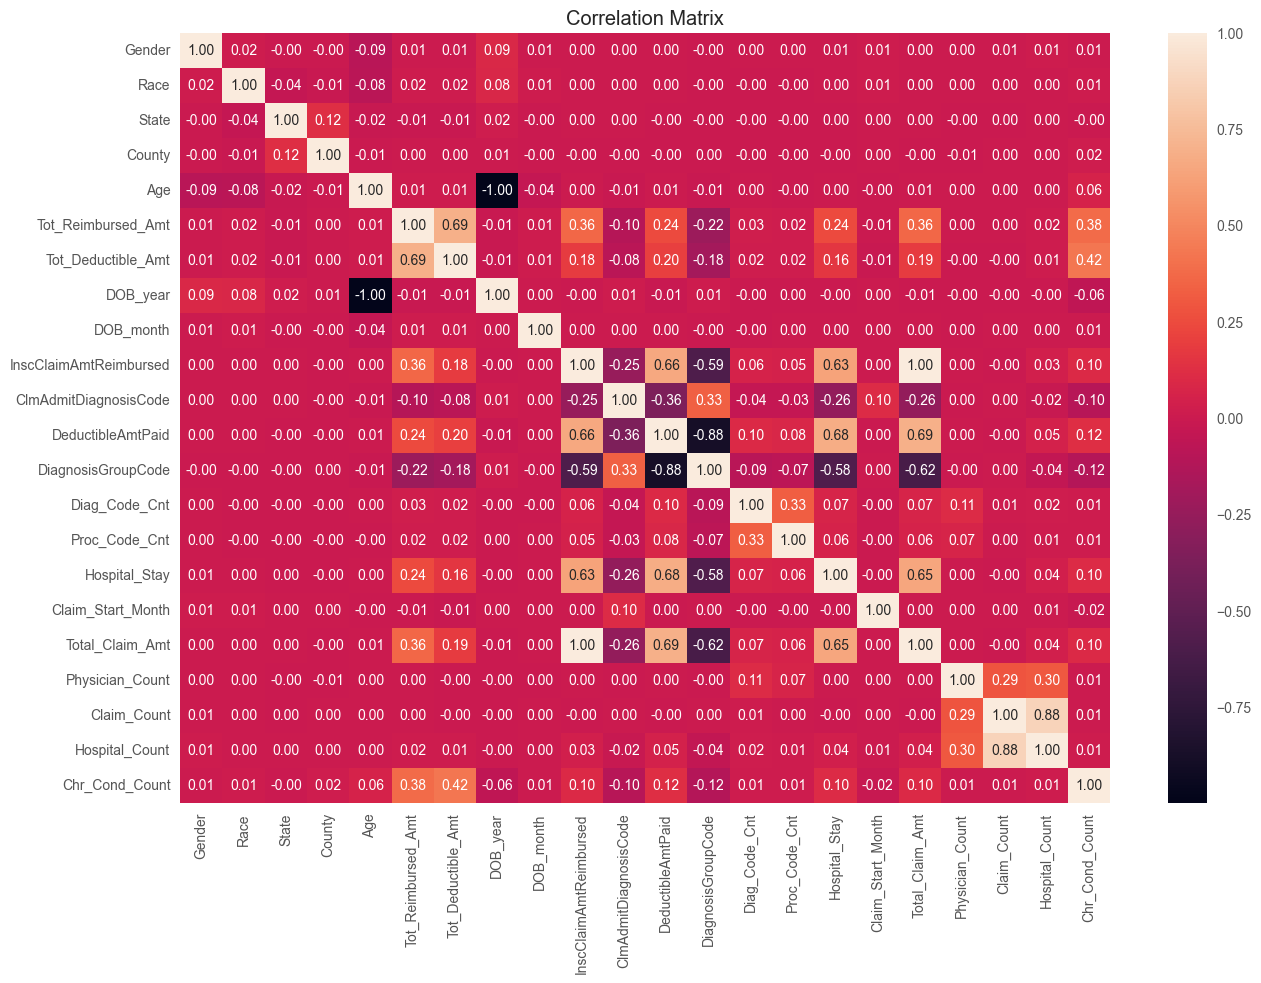

In [14]:
# Check correlation between 22 variables.
plt.figure(figsize=(15, 10))
sns.heatmap(trainX_BSM.corr(), annot= True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [15]:
# After checking correlation we dropped 2 more variables: DOB_year, DOB_month, 

trainX_BSM = trainX_BSM.drop(['DOB_year', 'DOB_month','Race', 'Diag_Code_Cnt', 'Proc_Code_Cnt', 'Hospital_Stay','Claim_Count',\
                              'DiagnosisGroupCode', 'Total_Claim_Amt'], axis=1)

testX_BSM = testX_BSM.drop(['DOB_year', 'DOB_month', 'Race', 'Diag_Code_Cnt', 'Proc_Code_Cnt', 'Hospital_Stay','Claim_Count',\
                            'DiagnosisGroupCode', 'Total_Claim_Amt'], axis=1)

In [16]:
trainX_BSM.shape

(483580, 13)

In [17]:
testX_BSM.shape

(207250, 13)

In [18]:
trainX_BSM.head()

,Gender,State,County,Age,Tot_Reimbursed_Amt,Tot_Deductible_Amt,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,Claim_Start_Month,Physician_Count,Hospital_Count,Chr_Cond_Count
0,0,1,400,57.0,850,810,0,3071,0.0,10,0,0,2
1,1,31,310,73.0,600,10,600,3763,0.0,7,0,0,2
2,0,28,540,88.0,7310,1948,5000,2390,1068.0,12,0,0,4
3,1,10,510,67.0,630,10,100,3763,0.0,12,0,0,5
4,0,24,720,76.0,2300,1470,10,3991,0.0,3,0,0,7


#### Correlation on 13 variables

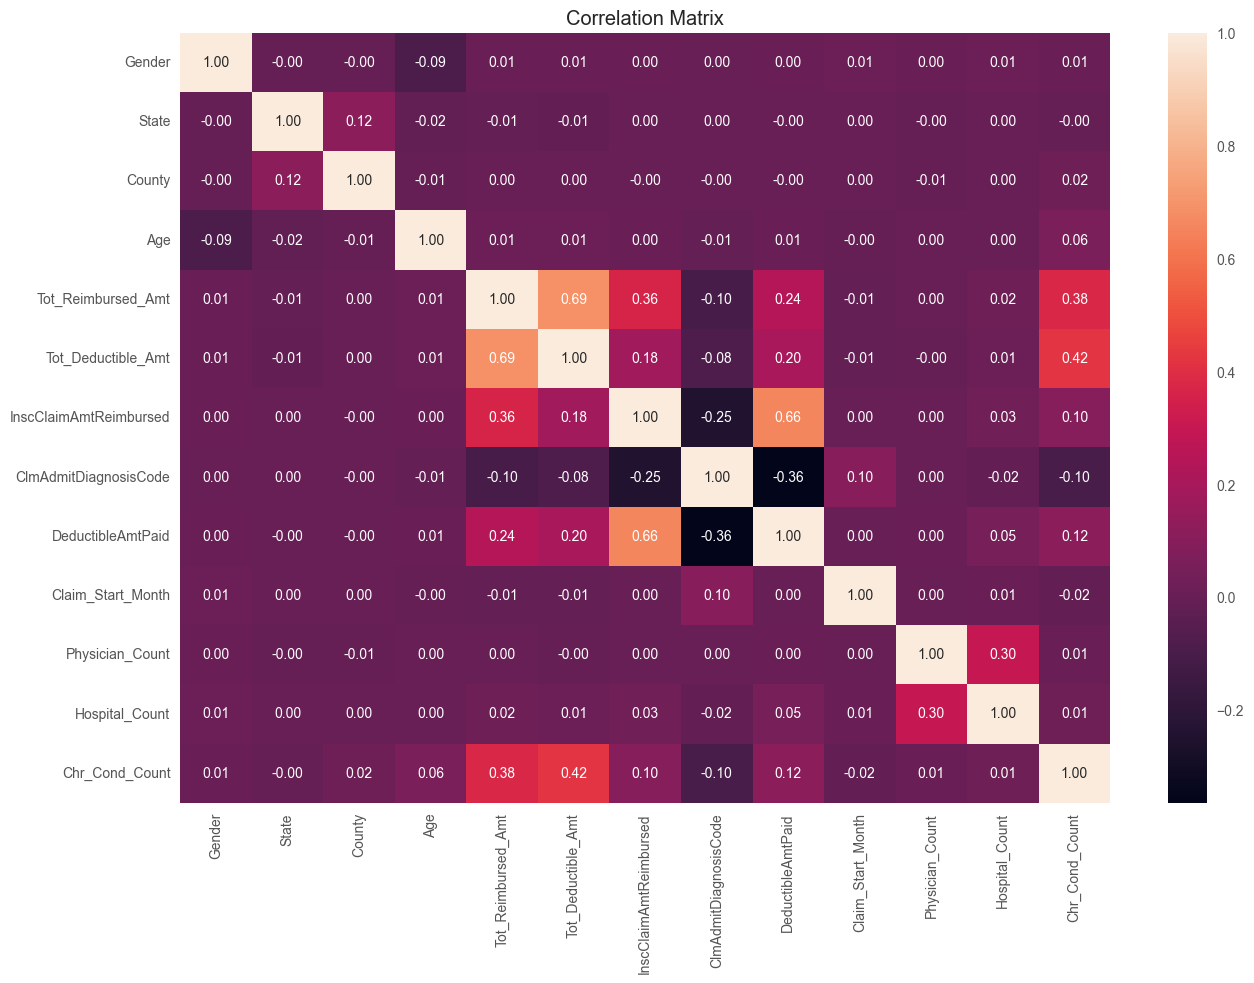

In [19]:
# Check again correlation between 13 variables.
plt.figure(figsize=(15, 10))
sns.heatmap(trainX_BSM.corr(), annot= True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Standardizing/Robust Scaling the train/test features for Balanced Dataset:
* StandardScaler removes the mean and scales the data to unit variance. Suitable for data that follows a normal distribution or when the presence of outliers is not a significant concern. 
* RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. Preferred when dealing with data containing outliers or when the distribution of the data is not normal.

In [4]:
from sklearn.preprocessing import StandardScaler,RobustScaler

def std_num_cols(df):
	# Creating a scalar object
	scaler = StandardScaler()
	# Standardizind the dataframe
	df = scaler.fit_transform(df)

def rb_scale_cols(df):
	# Creating a scalar object
	scaler = RobustScaler()
	# Standardizind the dataframe
	df = scaler.fit_transform(df)

### Function for model results

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

def model_results(X_train, y_train, X_test, y_test, model, show = True):

	model.fit(X_train, y_train)

	train_accr = model.score(X_train, y_train)
	test_accr = model.score(X_test, y_test)
	y_pred = model.predict(X_test)
	precision = precision_score(y_test, y_pred)
	avg_precision = average_precision_score(y_test, y_pred)
	recall = recall_score(y_test, y_pred)
	f1 = f1_score(y_test, y_pred)
	roc_auc = roc_auc_score(y_test, y_pred)
	tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
	corr_cls = tp+tn
	incorr_cls = fp+fn

	if show:
		print('The Model Results for ', model)
		print("*"*60)
		print('Train Accuracy is equal to %.3f' %round(train_accr,3))
		print('Test Accuracy is equal to %.3f' %round(test_accr,3))
		print('The Precision score is %.3f' %round(precision,3))
		print('The Average Precision score is %.3f' %round(avg_precision,3))
		print('The Recall score is %.3f' %round(recall,3))
		print('The F1 score is %.3f' %round(f1,3))
		print('The AUC/ROC score is %.3f' %round(roc_auc,3))
		print("True-Positive: %.3f" %tp)
		print("True-Negative: %.3f" %tn)
		print("False-Positive: %.3f" %fp)
		print("False-Negative: %.3f" %fn)
		print("Correctly Classified: %.3f" %corr_cls)
		print("Incorrectly Classified: %.3f" %incorr_cls)

	return [train_accr, test_accr, precision, recall]

---
## *** LightGBM Models ***
---

### Standardizing the train/test features for balanced datasets

In [20]:
# Borderline SMOTE balanced dataset
# Standard Scaler
std_num_cols(trainX_BSM)
std_num_cols(testX_BSM)

### Baseline LightGBM Classifier Model - Standardized

In [21]:
# BorderlineSMOTE Balanced

lgbm_std_bsm = lgb.LGBMClassifier()
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, lgbm_std_bsm, show = True)

[LightGBM] [Info] Number of positive: 241790, number of negative: 241790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 483580, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The Model Results for  LGBMClassifier()
************************************************************
Train Accuracy is equal to 0.774
Test Accuracy is equal to 0.775
The Precision score is 0.823
The Average Precision score is 0.726
The Recall score is 0.700
The F1 score is 0.756
The AUC/ROC score is 0.775
True-Positive: 72553.000
True-Negative: 87990.000
False-Positive: 15635.000
False-Negative: 31072.000
Correctly Classified: 160543.000
Incorrectly Classified: 46707.000


[0.7742400430125316,
 0.7746344993968637,
 0.8227083049848052,
 0.7001495778045839]

### Robust Scaling the train/test features for balanced datasets

In [22]:
# BorderlineSMOTE balanced dataset

rb_scale_cols(trainX_BSM)
rb_scale_cols(testX_BSM)

### Baseline LightGBM Classifier Model - Robust Scaled

In [23]:
# BorderlineSMOTE Balanced

lgbm_bsm = lgb.LGBMClassifier()
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, lgbm_bsm, show = True)

[LightGBM] [Info] Number of positive: 241790, number of negative: 241790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 483580, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The Model Results for  LGBMClassifier()
************************************************************
Train Accuracy is equal to 0.774
Test Accuracy is equal to 0.775
The Precision score is 0.823
The Average Precision score is 0.726
The Recall score is 0.700
The F1 score is 0.756
The AUC/ROC score is 0.775
True-Positive: 72553.000
True-Negative: 87990.000
False-Positive: 15635.000
False-Negative: 31072.000
Correctly Classified: 160543.000
Incorrectly Classified: 46707.000


[0.7742400430125316,
 0.7746344993968637,
 0.8227083049848052,
 0.7001495778045839]

### Feature Selection with RFE

In [24]:
# Extracting top 10 best features with RFE:

lgb_bsm = lgb.LGBMClassifier(subsample=1, n_estimators=130, num_leaves=100,\
                      max_depth=7, learning_rate=0.6352, colsample_bytree=1)

rfe = RFE(estimator=lgb_bsm, n_features_to_select=10, step=10)

# Running model to compare performance

model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe, show=True)

[LightGBM] [Info] Number of positive: 241790, number of negative: 241790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 483580, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[0.8314839323379792,
 0.8068371531966224,
 0.8321494233662042,
 0.7687334137515078]

In [26]:
# Looking at RFE feature selection

print(trainX_BSM.columns[rfe.support_])

Index(['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
       'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
       'Claim_Start_Month', 'Chr_Cond_Count'],
      dtype='object')


### Model with selected features from RFE - Final LightGBM Model

In [27]:
# Model using RFE 10 features

lgb_bsm = lgb.LGBMClassifier(subsample=1, n_estimators=130, num_leaves=100,\
                             max_depth=7, learning_rate=0.6352, colsample_bytree=1)

selected_feat = trainX_BSM.columns[rfe.support_]

model_results(trainX_BSM[selected_feat], trainY_BSM, testX_BSM[selected_feat], testY_BSM, lgb_bsm, show=True)

[LightGBM] [Info] Number of positive: 241790, number of negative: 241790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 483580, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[0.8314839323379792,
 0.8068371531966224,
 0.8321494233662042,
 0.7687334137515078]

#### Feature Importance

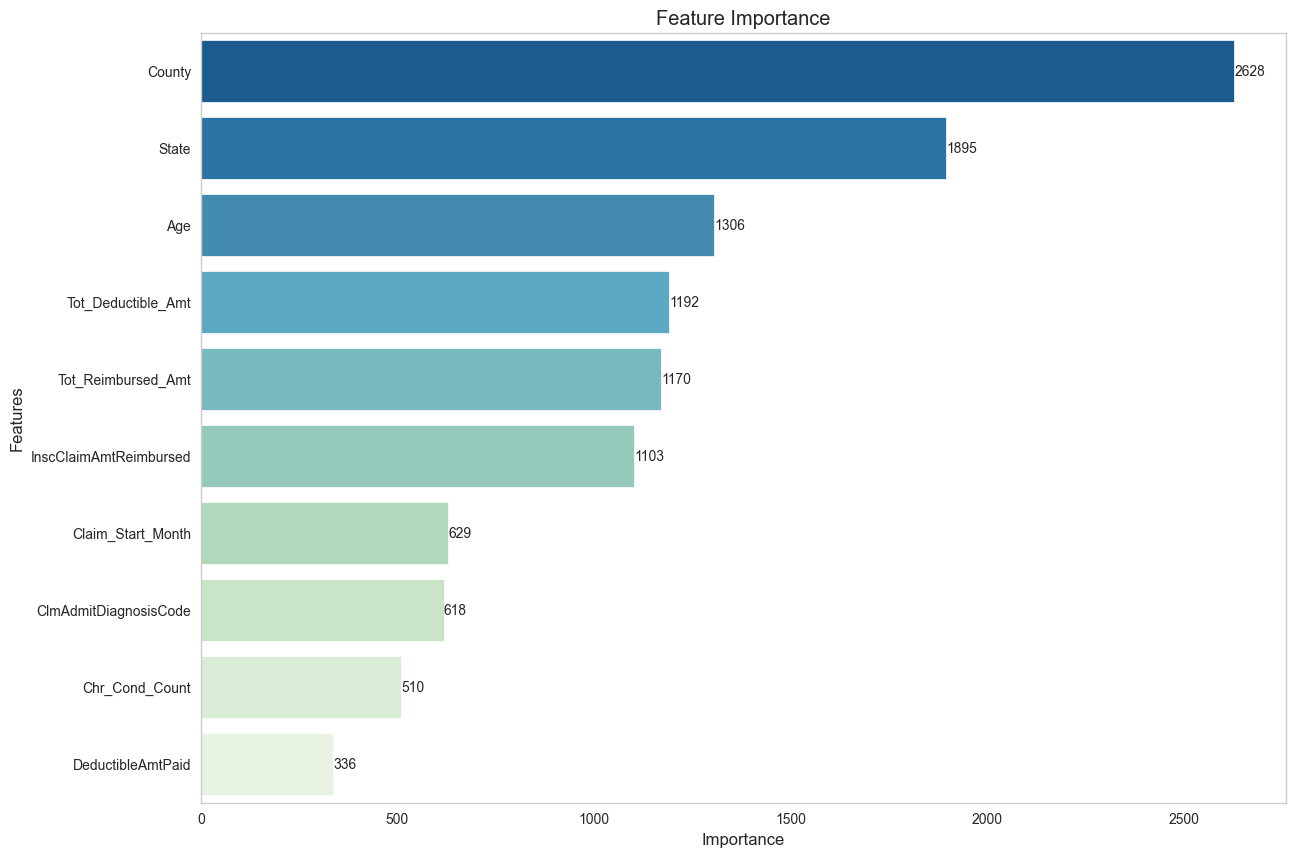

In [28]:
sns.set_style("whitegrid")
# LightGBM model
importance = lgb_bsm.feature_importances_
feature_names = lgb_bsm.feature_name_

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort the features by importance and select the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(14, 10))
splot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='GnBu_r')

# Add annotations
for p in splot.patches:
    width = p.get_width()
    plt.text(int(width) + 0.5, p.get_y() + p.get_height() / 2, f'{int(width)}', 
             ha='left', va='center')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
# Remove the grid
plt.grid(False) 
plt.show()

### Model metrics for final LightGBM Model

#### Confusion Matrix

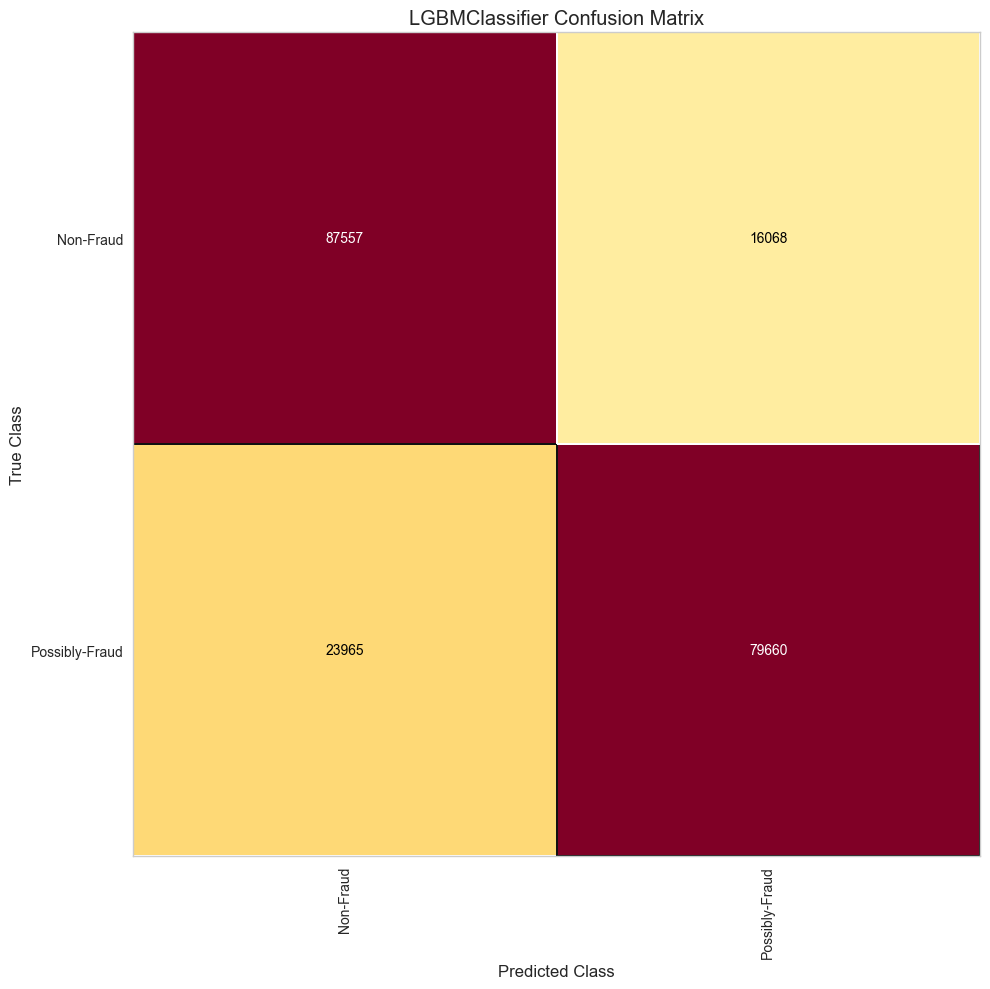

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)
classes=['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))
visualizer = ConfusionMatrix(lgb_bsm, classes=classes)

visualizer.fit(trainX_BSM[selected_feat], trainY_BSM)
visualizer.score(testX_BSM[selected_feat], testY_BSM)
visualizer.show()

#### AUC/ROC curve

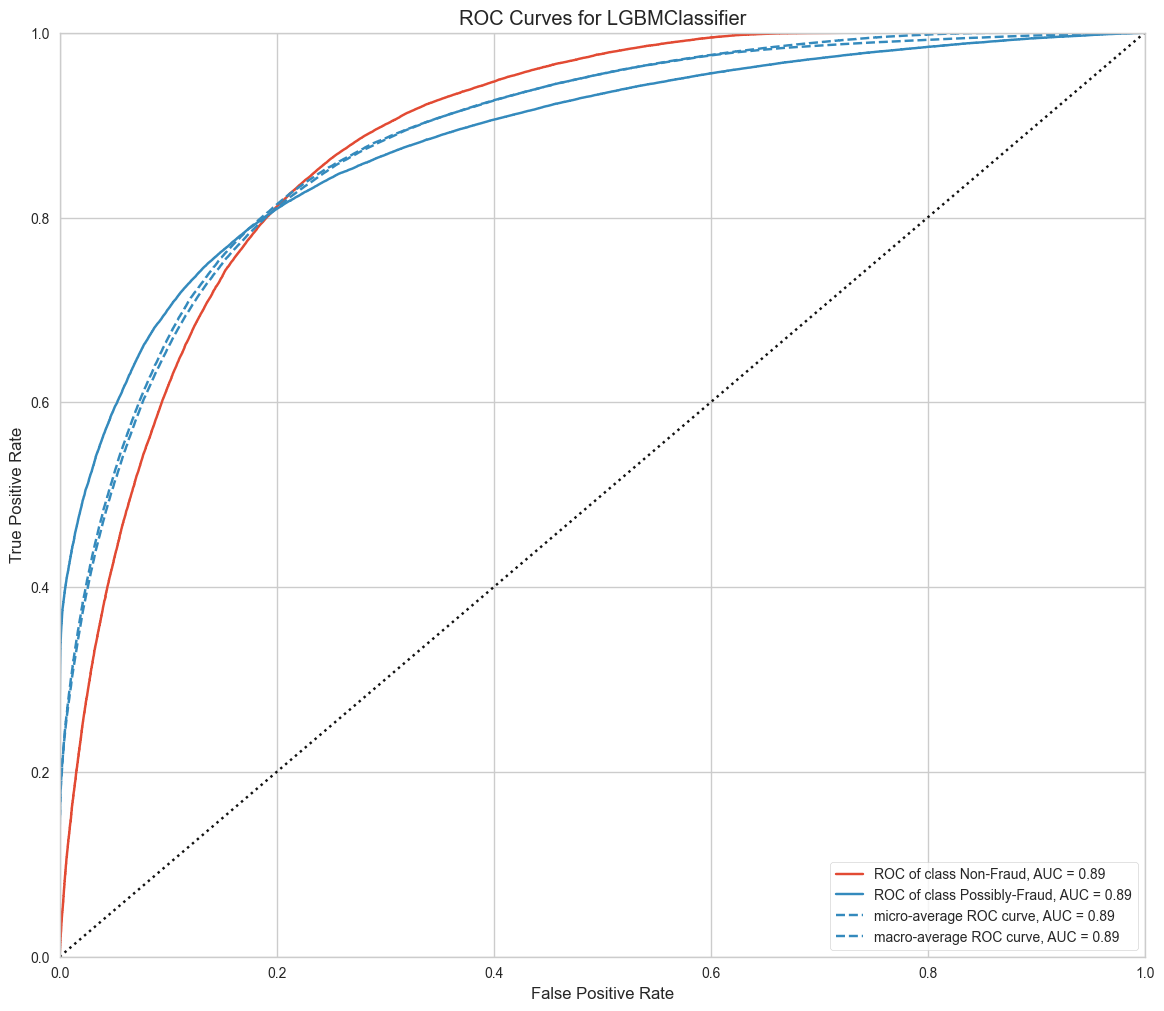

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [30]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(lgb_bsm, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_BSM[selected_feat], trainY_BSM)        # Fit the training data to the visualizer
visualizer.score(testX_BSM[selected_feat], testY_BSM)        # Evaluate the model on the test data

visualizer.show()

#### Classification report

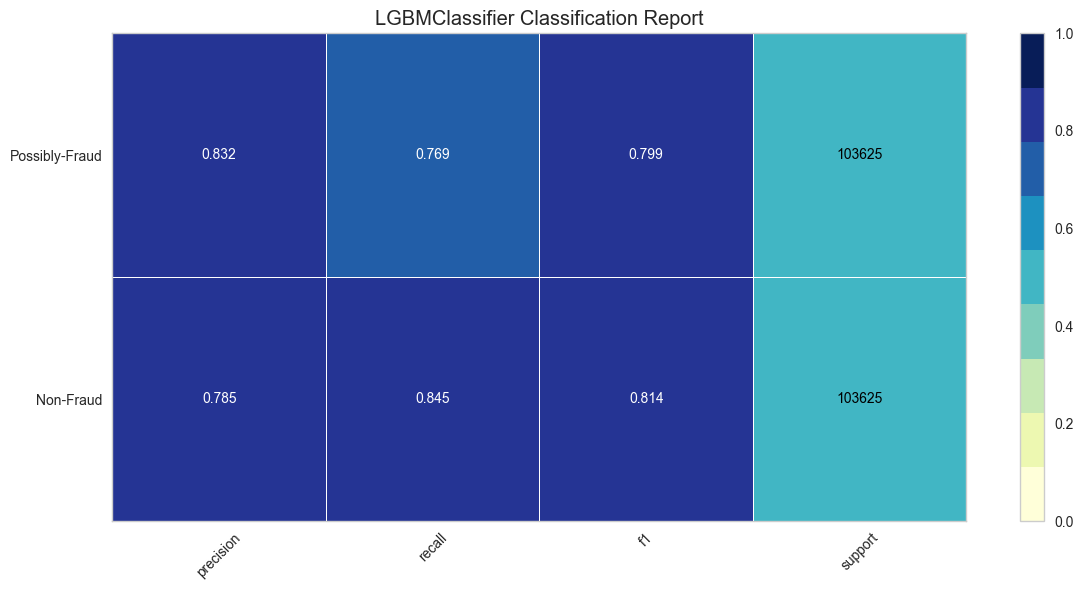

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [31]:
# Visualizing the classification report with Yellowbricks

plt.figure(figsize = (12,6))
sns.set_style("whitegrid")

visualizer = classification_report(
    lgb_bsm,
    trainX_BSM[selected_feat], trainY_BSM, testX_BSM[selected_feat], testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True)

visualizer.show()

#### Prediction Error

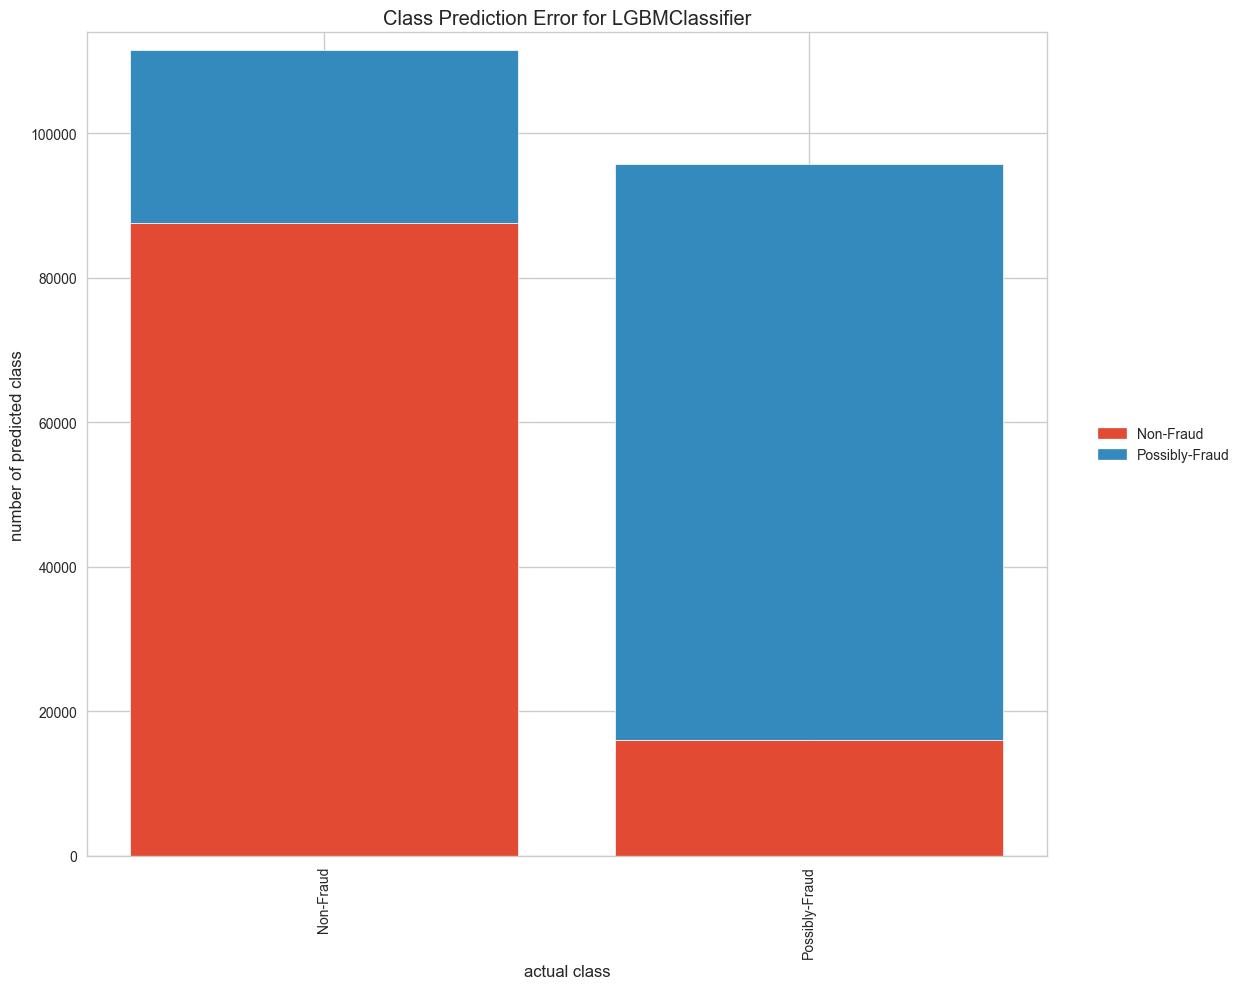

<Axes: title={'center': 'Class Prediction Error for LGBMClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [32]:
from yellowbrick.classifier import class_prediction_error
# Visualizing prediction error

plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
    lgb_bsm,
    trainX_BSM[selected_feat], trainY_BSM.values.ravel(),
    testX_BSM[selected_feat], testY_BSM.values.ravel(),
    classes=['Non-Fraud', 'Possibly-Fraud'])

viz.show()

#### SHAP Feature Importance Visualization

In [33]:
sns.set_style("whitegrid")

# BSM - Explain the model's predictions using SHAP

BSMexplainer = shap.TreeExplainer(lgb_bsm)
BSMshap_values = BSMexplainer.shap_values(testX_BSM[selected_feat])

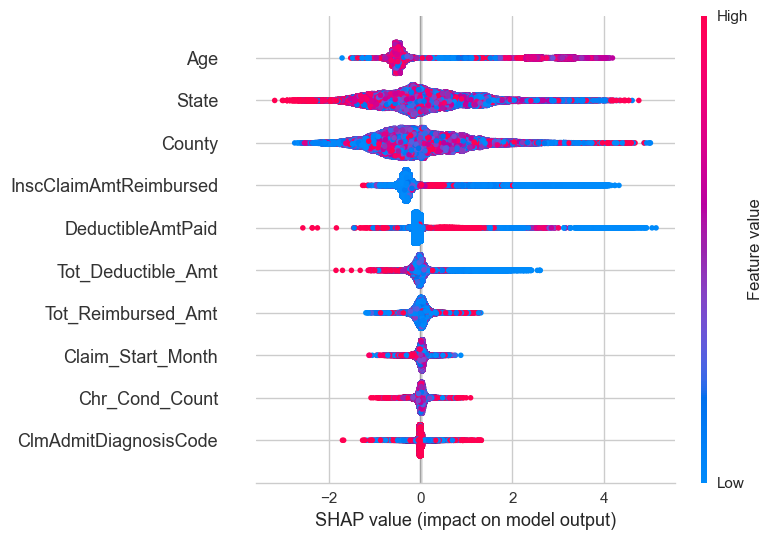

In [34]:
shap.summary_plot(BSMshap_values,testX_BSM[selected_feat])

---
## *** XGBoost Models ***
---

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,\
StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,f1_score
from sklearn.feature_selection import RFE
from yellowbrick.classifier import ConfusionMatrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
#from cp_clean_helper import show_values
#from LGR_helper import std_num_cols, rb_scale_cols, model_results, get_confusion_matrix
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

### Baseline XGBoost Classifier Model - Standardized

In [36]:
# Standard Scaler
std_num_cols(trainX_BSM)
std_num_cols(testX_BSM)

In [37]:
# XGBoost Classifier Model 
xg_std_bsm = XGBClassifier()
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, xg_std_bsm, show = True)

The Model Results for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
************************************************************
Train Accuracy is equal to 0.787
Test Accuracy is equal to 0.781
The Precision score is 0.813
The Average Precision score is 0.729
The Recall score is 0.730
T

[0.786972165929112, 0.7810615199034981, 0.8131316389283103, 0.7298528347406514]

### Baseline XGBoost Classifier Model - Robust

In [38]:
# Robust Scaler
rb_scale_cols(trainX_BSM)
rb_scale_cols(testX_BSM)

In [39]:
xg_rb_bsm = XGBClassifier()
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, xg_rb_bsm, show = True)

The Model Results for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
************************************************************
Train Accuracy is equal to 0.787
Test Accuracy is equal to 0.781
The Precision score is 0.813
The Average Precision score is 0.729
The Recall score is 0.730
T

[0.786972165929112, 0.7810615199034981, 0.8131316389283103, 0.7298528347406514]

### Feature Selection with RFE

In [40]:
# Extracting top 10 best features with RFE:
xg_bsm = XGBClassifier(subsample=1, n_estimators=130, min_child_weight=7,\
                      max_depth=6, learning_rate=0.7395, colsample_bytree=0.7)
rfe1 = RFE(estimator=xg_bsm, n_features_to_select=10, step=10)

# Running model to compare performance
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe1, show=True)

The Model Results for  RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=0.7, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=0.7395, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=6, max_leaves=None,
                            min_child_weight=7, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=130, n_jobs=None,
                            num_parallel_tree=None, random_stat

[0.8059431738285289, 0.7944849215922799, 0.822736214226791, 0.7507165259348613]

In [41]:
# Looking at RFE feature selection
print(trainX_BSM.columns[rfe1.support_])


Index(['Gender', 'State', 'County', 'Age', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid', 'Claim_Start_Month', 'Physician_Count',
       'Hospital_Count', 'Chr_Cond_Count'],
      dtype='object')


### Model with selected features: Model using RFE 10 features

In [42]:
selected_feat1 = trainX_BSM.columns[rfe1.support_]
model_results(trainX_BSM[selected_feat1], trainY_BSM, testX_BSM[selected_feat1], testY_BSM, xg_bsm, show=True)

The Model Results for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7395, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
************************************************************
Train Accuracy is equal to 0.806
Test Accuracy is equal to 0.794
The Precision score is 0.823
The Average Precision score is 0.742
The Recall score is 0.751
The F1 

[0.8059431738285289, 0.7944849215922799, 0.822736214226791, 0.7507165259348613]

#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1400x1000 with 0 Axes>

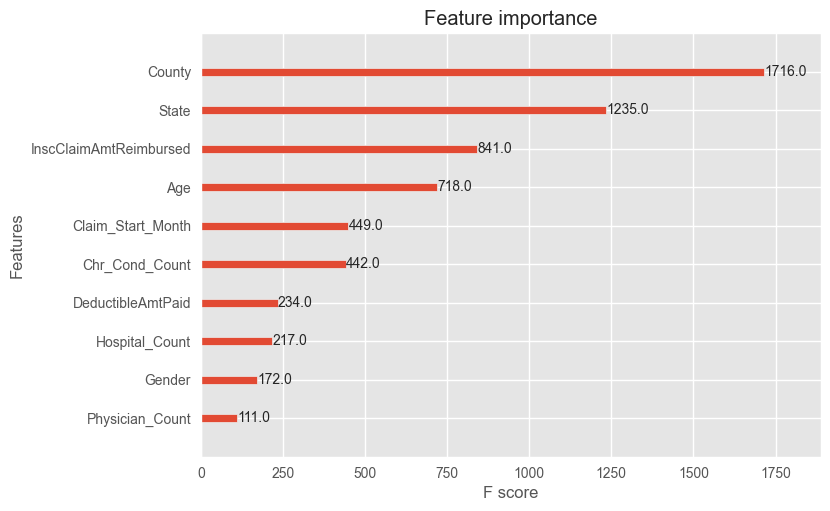

In [43]:
# XGBoost has built-in feature selection capabilities for feature selection and highlighting importance scores calculation.
plt.figure(figsize=(14, 10))

# Import library
from xgboost import plot_importance

# Plot feature selections
plot_importance(xg_bsm,importance_type='weight', max_num_features=10)

### Model metrics for XGBoost Model

#### Confusion Matrix

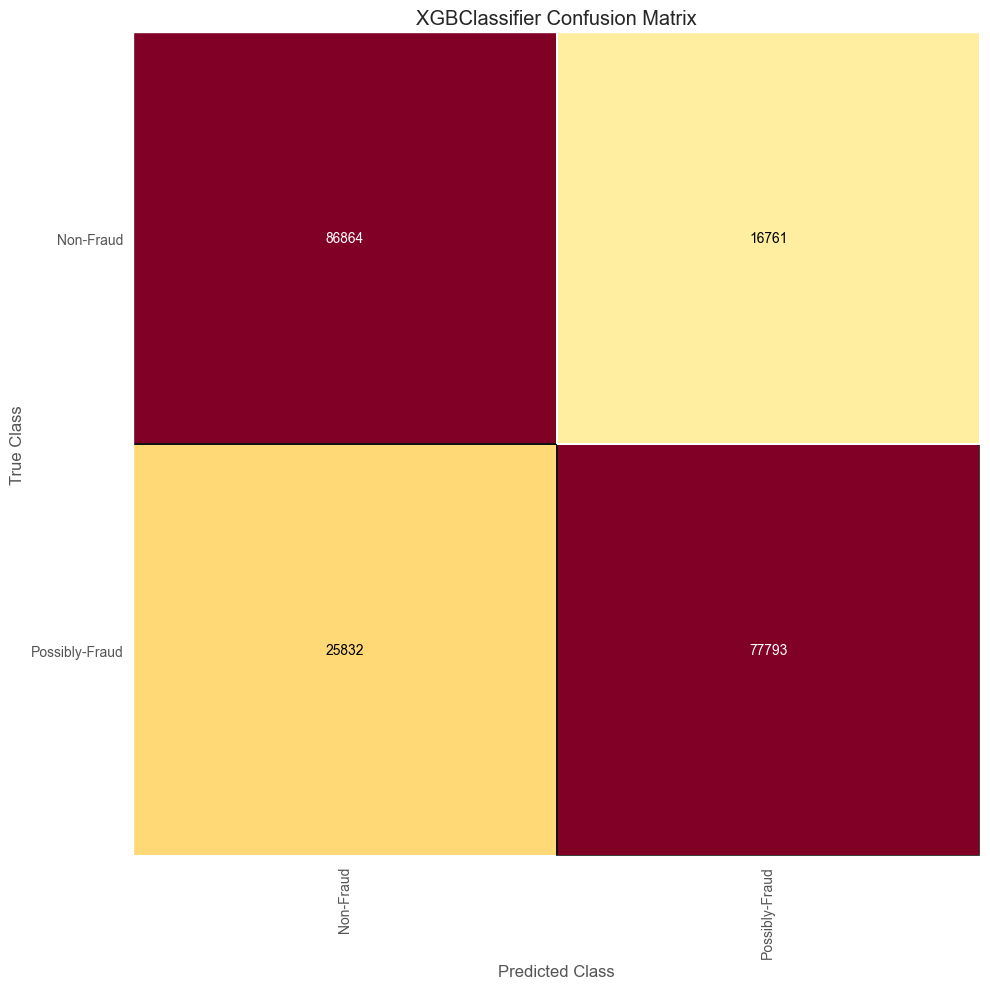

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [44]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)
plt.figure(figsize=(10, 10))

# Create the ConfusionMatrix visualizer
visualizer= ConfusionMatrix(xg_bsm, classes=['Non-Fraud', 'Possibly-Fraud'])

# Fit the training data to the visualizer
visualizer.fit(trainX_BSM[selected_feat1], trainY_BSM)

# Evaluate the model on the test data
visualizer.score(testX_BSM[selected_feat1], testY_BSM)

# Draw/save/show the data
visualizer.show()

#### AUC/ROC Curve

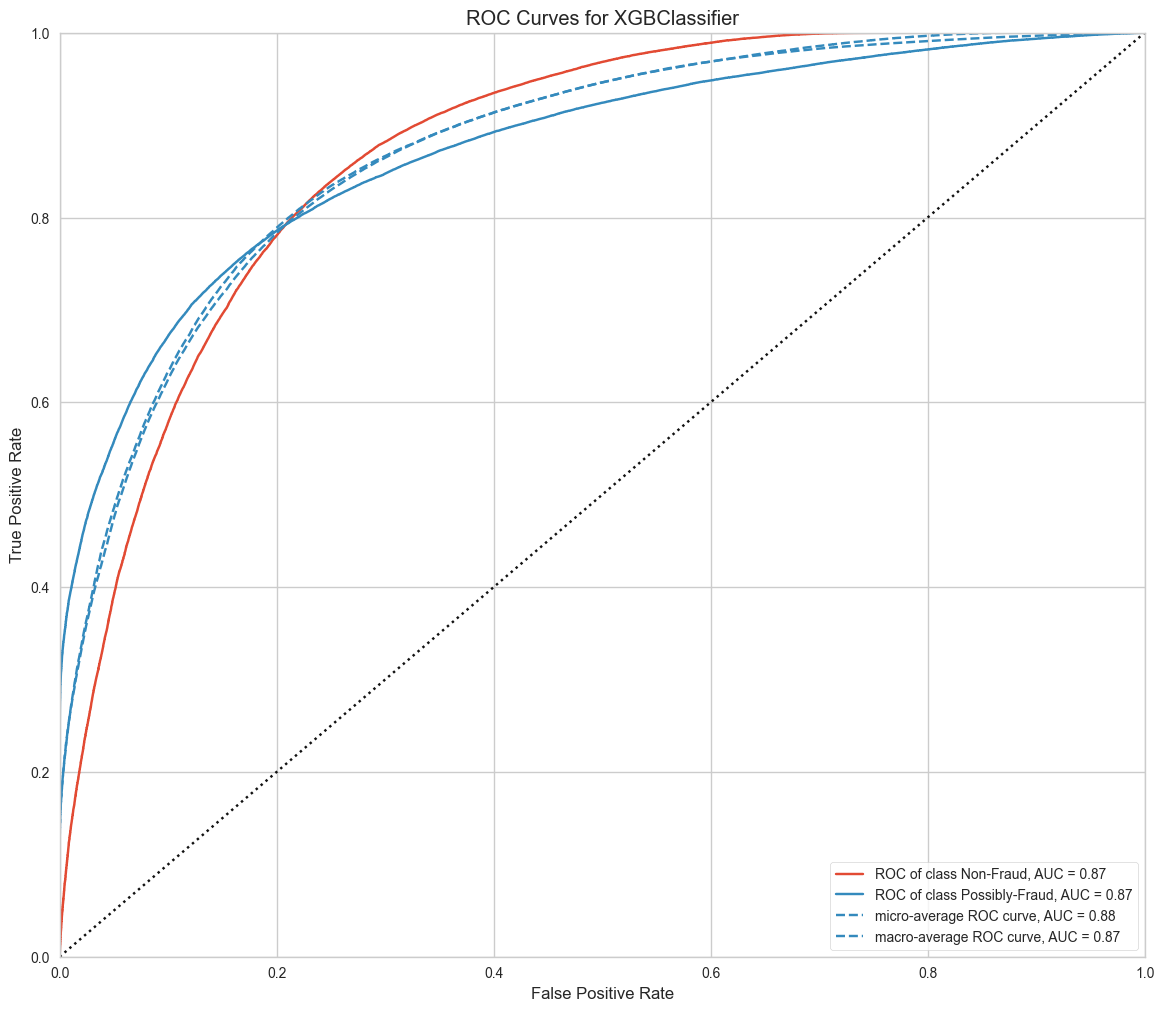

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [45]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(xg_bsm, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_BSM[selected_feat1], trainY_BSM)        # Fit the training data to the visualizer
visualizer.score(testX_BSM[selected_feat1], testY_BSM)        # Evaluate the model on the test data

visualizer.show()


#### Classification Report

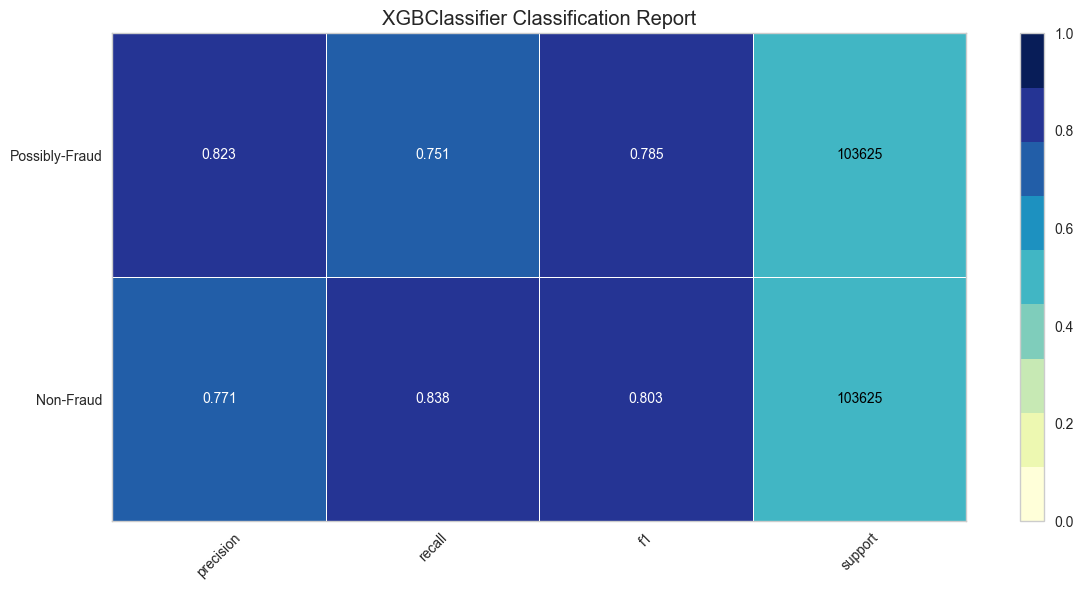

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [46]:
# Visualizing the classification report with Yellowbricks

plt.figure(figsize = (12,6))
sns.set_style("whitegrid")

visualizer = classification_report(
    xg_bsm,
    trainX_BSM[selected_feat1], trainY_BSM, testX_BSM[selected_feat1], testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True)

visualizer.show()


#### Prediction Error

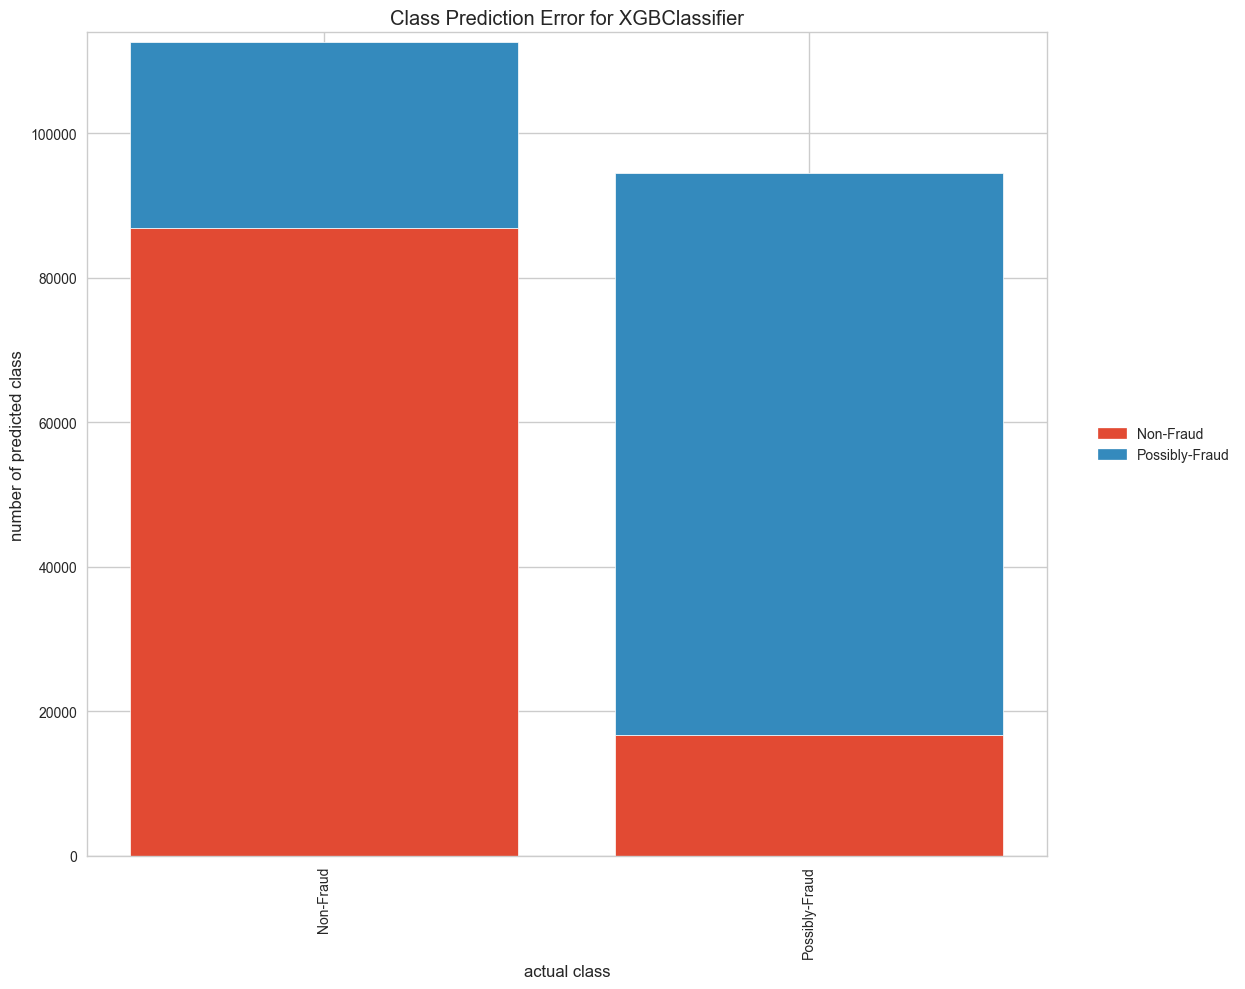

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [47]:
# Visualizing prediction error
from yellowbrick.classifier import class_prediction_error

plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
    xg_bsm,
    trainX_BSM[selected_feat1], trainY_BSM.values.ravel(),
    testX_BSM[selected_feat1], testY_BSM.values.ravel(),
    classes=['Non-Fraud', 'Possibly-Fraud'])

viz.show()

#### Model Explanation of Predictions - Using SHAP

In [60]:
BSMexplainer = shap.TreeExplainer(xg_bsm)
BSMshap_values1 = BSMexplainer.shap_values(testX_BSM[selected_feat1])

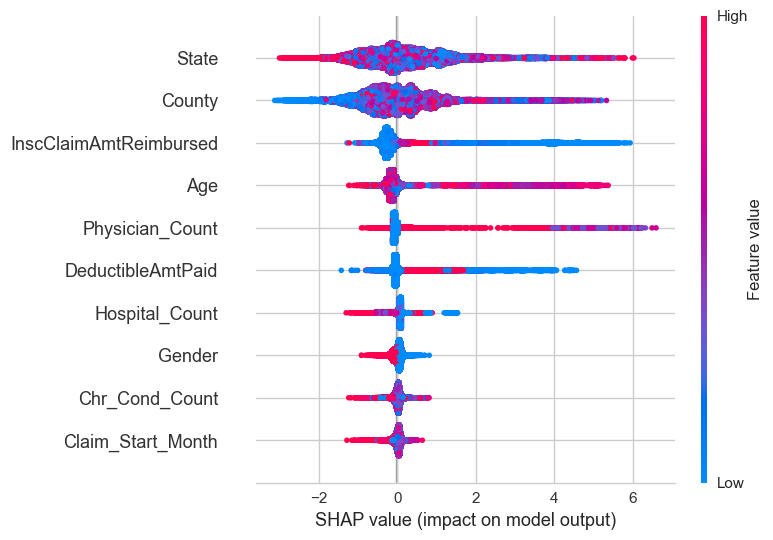

In [61]:
# Summary Plot
shap.summary_plot(BSMshap_values1, testX_BSM[selected_feat1])

### XGBoost Final Model using the same 10 features RFE selected for LightGBM

In [50]:
# Robust Scaler
rb_scale_cols(trainX_BSM)
rb_scale_cols(testX_BSM)

In [87]:
# Specify the 10 features we want to use
selected_features = ['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
                     'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
                     'Claim_Start_Month', 'Chr_Cond_Count']

# Filter the datasets to include only the selected features
trainX_BSM_filtered = trainX_BSM[selected_features]
testX_BSM_filtered = testX_BSM[selected_features]

# Instantiate the XGBoost classifier
#xg_bsm1 = XGBClassifier()
xg_bsm1 = XGBClassifier(subsample=1, n_estimators=130, min_child_weight=7,\
                      max_depth=6, learning_rate=0.7395, colsample_bytree=0.7)

# Run the model with the filtered datasets
model_results(trainX_BSM_filtered, trainY_BSM, testX_BSM_filtered, testY_BSM, xg_bsm1, show=True)

The Model Results for  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7395, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
************************************************************
Train Accuracy is equal to 0.805
Test Accuracy is equal to 0.790
The Precision score is 0.816
The Average Precision score is 0.737
The Recall score is 0.750
The F1 

[0.8052793746639646, 0.7901375150784077, 0.81560521923517, 0.7497901085645355]

#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

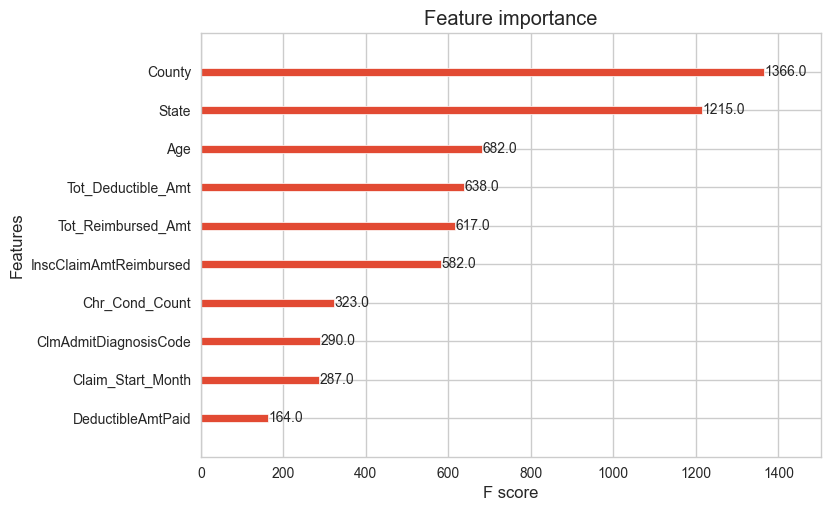

In [81]:
# Import library
from xgboost import plot_importance

# Plot feature selections
plot_importance(xg_bsm1,importance_type='weight', max_num_features=10)

### Model metrics for Final XGBoost Model

#### Confusion Matrix

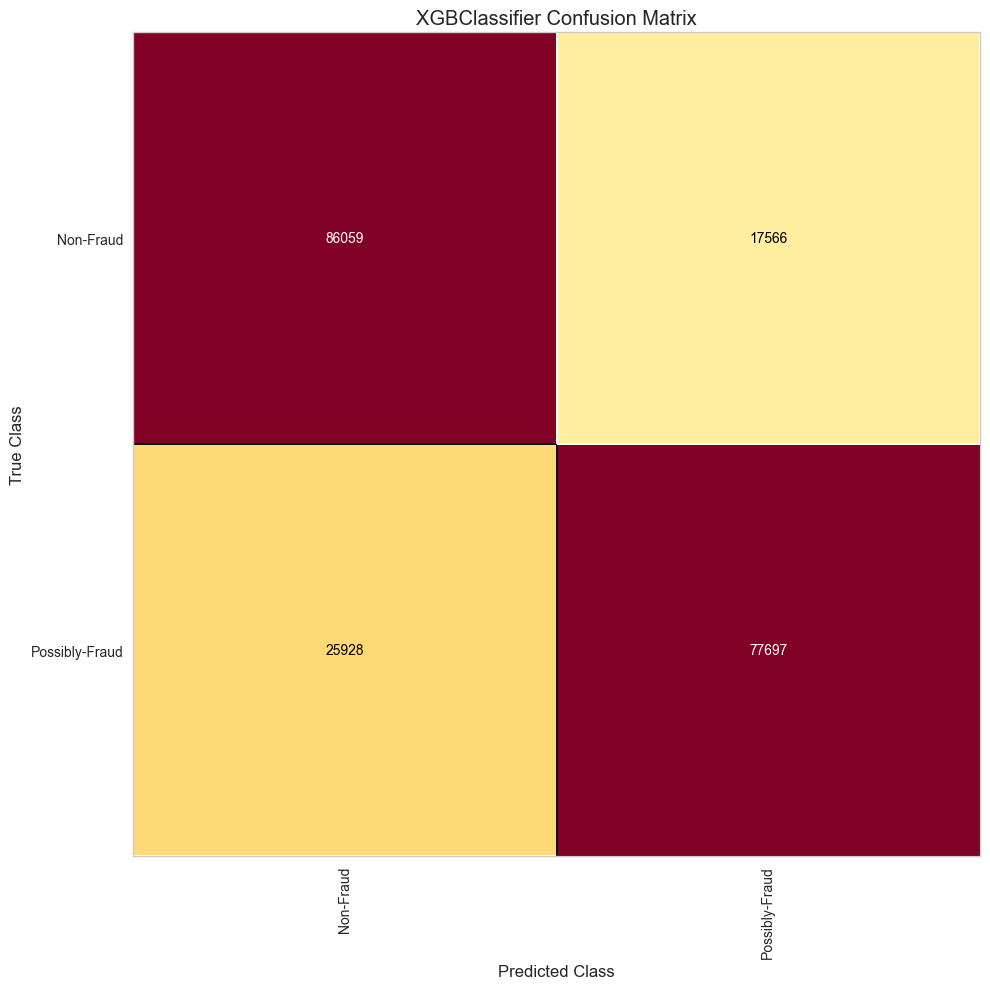

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [88]:
# Visualizing the confusion matrix with Yellowbricks (thres=0.5)
plt.figure(figsize=(10, 10))

# Create the ConfusionMatrix visualizer
visualizer= ConfusionMatrix(xg_bsm1, classes=['Non-Fraud', 'Possibly-Fraud'])

# Fit the training data to the visualizer
visualizer.fit(trainX_BSM_filtered[selected_features], trainY_BSM)

# Evaluate the model on the test data
visualizer.score(testX_BSM_filtered[selected_features], testY_BSM)

# Draw/save/show the data
visualizer.show()

#### AUC/ROC Curve

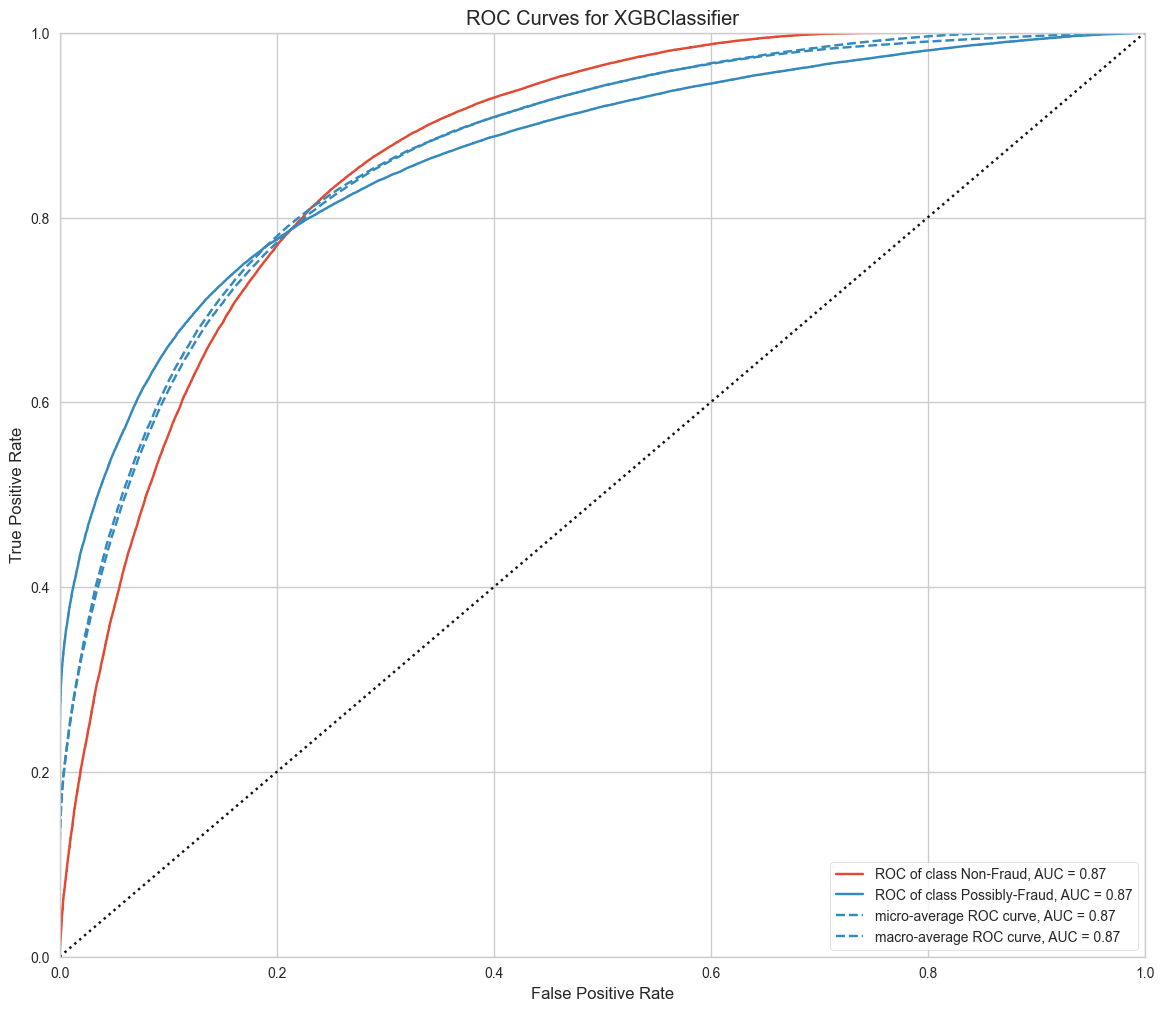

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [89]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
sns.set_style("whitegrid")

visualizer = ROCAUC(xg_bsm1, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_BSM_filtered[selected_features], trainY_BSM)        # Fit the training data to the visualizer
visualizer.score(testX_BSM_filtered[selected_features], testY_BSM)        # Evaluate the model on the test data

visualizer.show()

#### Classification Report

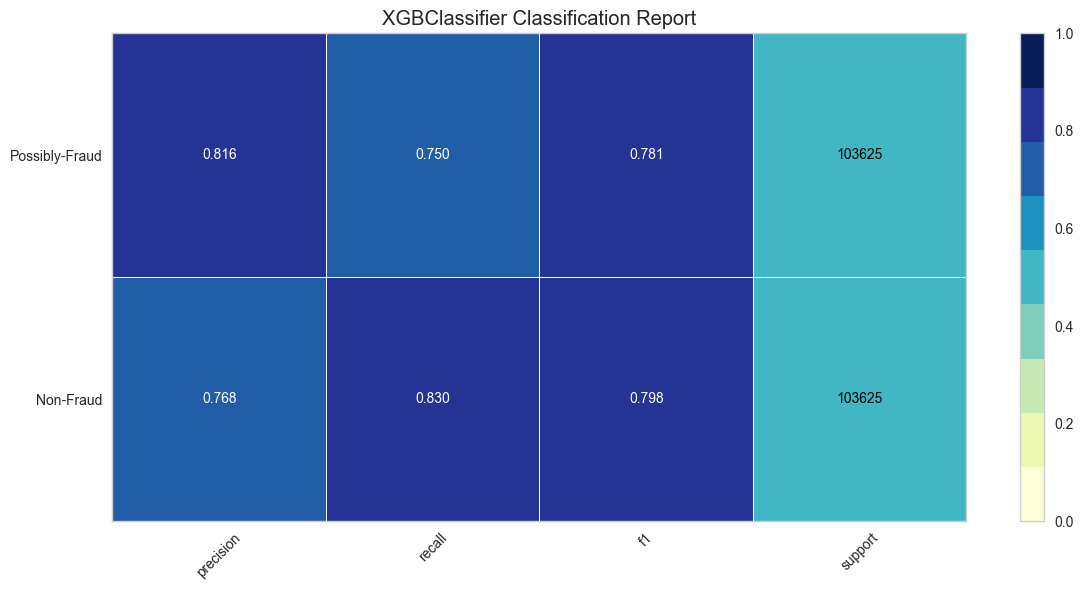

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [90]:
# Fit the model
xg_bsm1.fit(trainX_BSM_filtered, trainY_BSM)

# Visualize the classification report with Yellowbrick
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

visualizer = classification_report(
    xg_bsm1,
    trainX_BSM_filtered, trainY_BSM, testX_BSM_filtered, testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True
)
visualizer.show()

#### Prediction Error

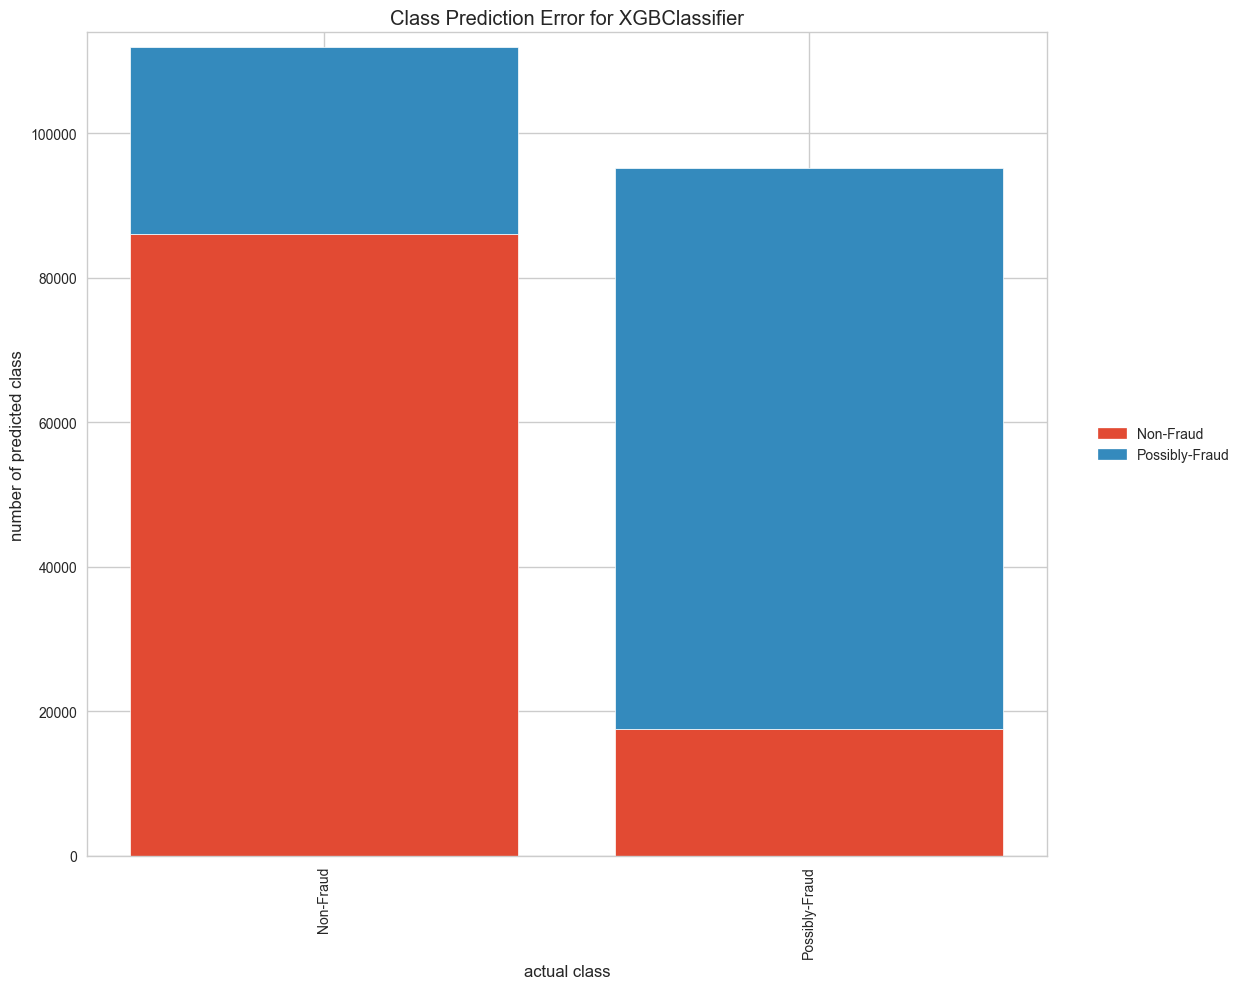

<Axes: title={'center': 'Class Prediction Error for XGBClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [91]:
# Visualizing prediction error
from yellowbrick.classifier import class_prediction_error

plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
    xg_bsm1,
    trainX_BSM_filtered[selected_features], trainY_BSM.values.ravel(),
    testX_BSM_filtered[selected_features], testY_BSM.values.ravel(),
    classes=['Non-Fraud', 'Possibly-Fraud'])

viz.show()

#### Model Explanation of Predictions - Using SHAP

In [92]:
BSMexplainer = shap.TreeExplainer(xg_bsm1)
BSMshap_values2 = BSMexplainer.shap_values(testX_BSM_filtered[selected_features])

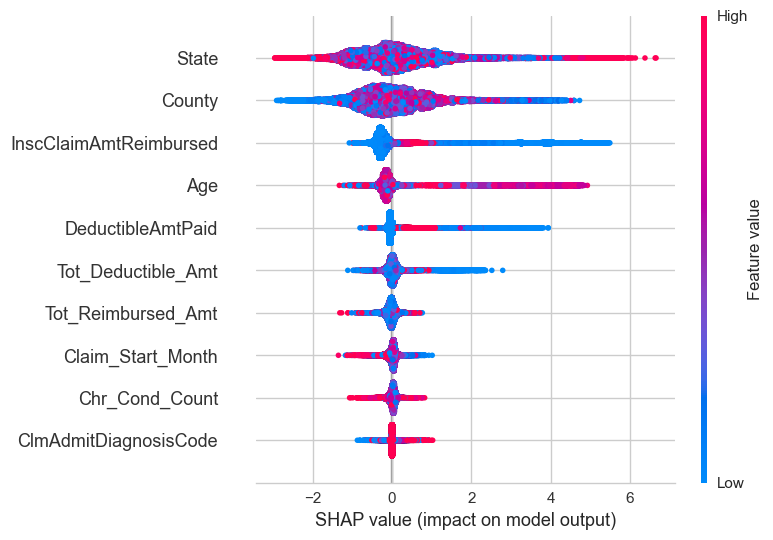

In [93]:
# Summary Plot
shap.summary_plot(BSMshap_values2, testX_BSM_filtered[selected_features])

---
## *** Random Forest Models ***
---

In [62]:
# Import Libraries
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,\
StratifiedKFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score
from sklearn.metrics import classification_report as cl_rep_skl
from yellowbrick.classifier import ConfusionMatrix, classification_report, ROCAUC
from yellowbrick.model_selection import CVScores
from sklearn import tree
#import graphviz as gv
from IPython.display import display
from IPython.display import SVG
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)


### Random Forest - Standardized 


In [63]:
# Standard Scaler
std_num_cols(trainX_BSM)
std_num_cols(testX_BSM)

In [64]:
# Random Forest Classifier Model
rf_std_bsm = RandomForestClassifier(random_state=0)
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rf_std_bsm, show = True)


The Model Results for  RandomForestClassifier(random_state=0)
************************************************************
Train Accuracy is equal to 0.999
Test Accuracy is equal to 0.747
The Precision score is 0.769
The Average Precision score is 0.690
The Recall score is 0.705
The F1 score is 0.735
The AUC/ROC score is 0.747
True-Positive: 73004.000
True-Negative: 81723.000
False-Positive: 21902.000
False-Negative: 30621.000
Correctly Classified: 154727.000
Incorrectly Classified: 52523.000


[0.9988709210471897,
 0.7465717732207479,
 0.7692242850820812,
 0.7045018094089264]

### Random Forest - Robust

In [65]:
# Robust Scaler
rb_scale_cols(trainX_BSM)
rb_scale_cols(trainY_BSM)


In [66]:
rf_bsm = RandomForestClassifier(random_state=0, oob_score=True)
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rf_bsm, show = True)

# Out of bag error:
rf_bsm.oob_score_

The Model Results for  RandomForestClassifier(oob_score=True, random_state=0)
************************************************************
Train Accuracy is equal to 0.999
Test Accuracy is equal to 0.747
The Precision score is 0.769
The Average Precision score is 0.690
The Recall score is 0.705
The F1 score is 0.735
The AUC/ROC score is 0.747
True-Positive: 73004.000
True-Negative: 81723.000
False-Positive: 21902.000
False-Negative: 30621.000
Correctly Classified: 154727.000
Incorrectly Classified: 52523.000


0.760935108978866

### Feature Selection with RFE

In [67]:
# Feature Selection with RFE
from sklearn.feature_selection import RFE

# Extracting top 10 best features with RFE:
rfe2 = RFE(estimator=rf_bsm, n_features_to_select=10, step=10)

# Running model to compare performance
model_results(trainX_BSM, trainY_BSM, testX_BSM, testY_BSM, rfe2, show=True)

The Model Results for  RFE(estimator=RandomForestClassifier(oob_score=True, random_state=0),
    n_features_to_select=10, step=10)
************************************************************
Train Accuracy is equal to 0.999
Test Accuracy is equal to 0.755
The Precision score is 0.778
The Average Precision score is 0.698
The Recall score is 0.712
The F1 score is 0.744
The AUC/ROC score is 0.755
True-Positive: 73789.000
True-Negative: 82606.000
False-Positive: 21019.000
False-Negative: 29836.000
Correctly Classified: 156395.000
Incorrectly Classified: 50855.000


[0.9987882046403904,
 0.7546200241254524,
 0.7782992996371614,
 0.7120772014475272]

In [68]:
# Looking at RFE feature selection
print(trainX_BSM.columns[rfe2.support_])

Index(['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
       'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode', 'Claim_Start_Month',
       'Hospital_Count', 'Chr_Cond_Count'],
      dtype='object')


### Model using RFE 10 Features

In [69]:
selected_feat2 = trainX_BSM.columns[rfe2.support_]
model_results(trainX_BSM[selected_feat2], trainY_BSM, testX_BSM[selected_feat2], testY_BSM, rf_bsm, show=True)

The Model Results for  RandomForestClassifier(oob_score=True, random_state=0)
************************************************************
Train Accuracy is equal to 0.999
Test Accuracy is equal to 0.755
The Precision score is 0.778
The Average Precision score is 0.698
The Recall score is 0.712
The F1 score is 0.744
The AUC/ROC score is 0.755
True-Positive: 73789.000
True-Negative: 82606.000
False-Positive: 21019.000
False-Negative: 29836.000
Correctly Classified: 156395.000
Incorrectly Classified: 50855.000


[0.9987882046403904,
 0.7546200241254524,
 0.7782992996371614,
 0.7120772014475272]

In [70]:
# Creating feature importance table:
feature_imp_df1 = pd.DataFrame(zip(selected_feat2,\
abs(rf_bsm.feature_importances_)),
columns=["Feature Name", "Weight"])
feature_imp_df1 = feature_imp_df1.sort_values("Weight", ascending=False)\
.reset_index(drop=True)

# Looking at top 10 features
top_features1 = feature_imp_df1.head(20)

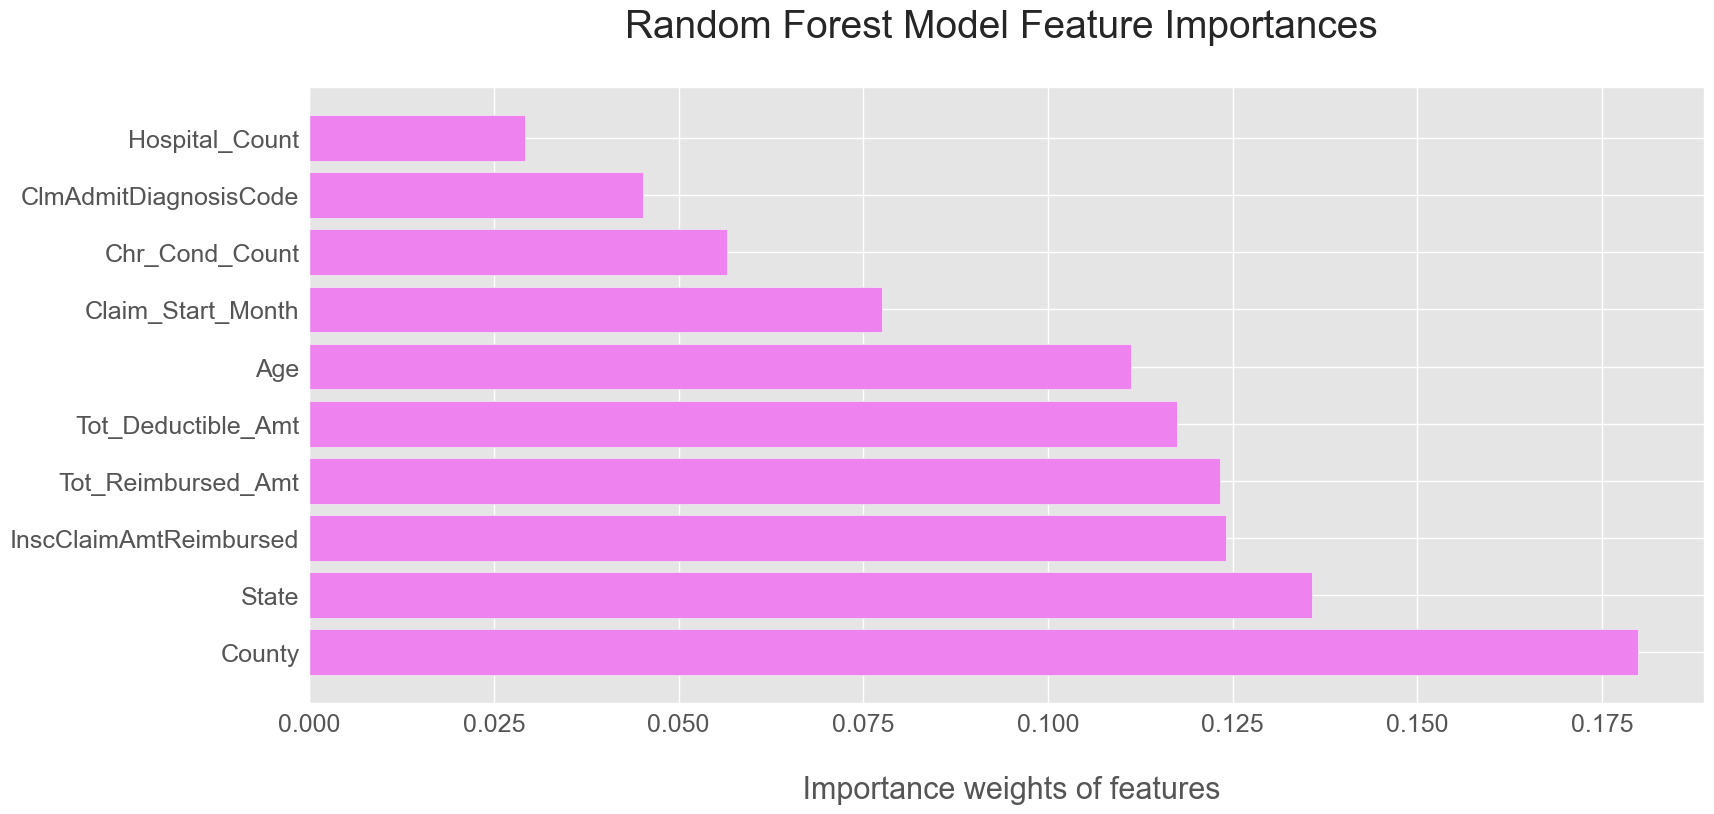

In [71]:
# Visualizing the results
plt.figure(figsize = (18,8))

plt.barh(top_features1["Feature Name"].head(15), top_features1["Weight"].head(15), color ="violet")
plt.xlabel("\n Importance weights of features", fontsize = 22)
plt.title("Random Forest Model Feature Importances \n", fontsize = 28)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

### Random Forest Metrics

#### Confusion Matrix

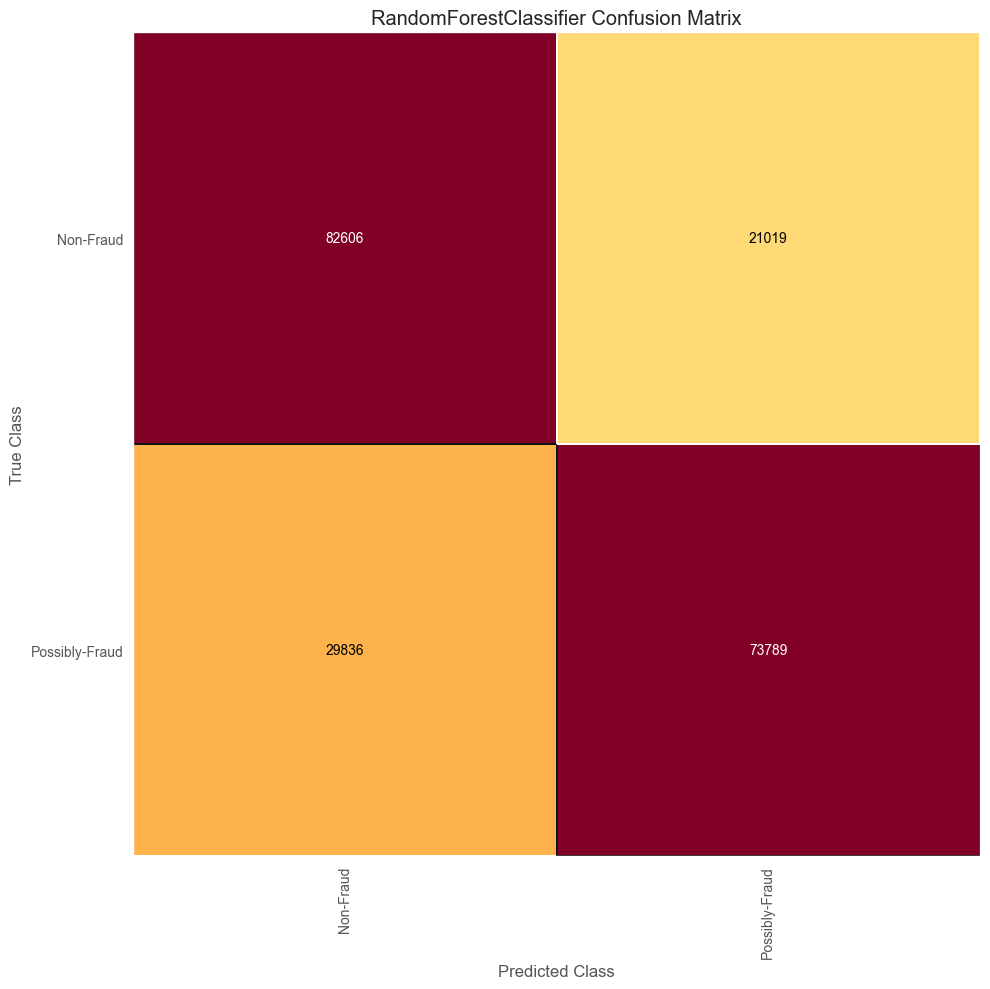

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [72]:
# Confusion Matrix

# Visualizing the confusion matrix with Yellowbricks (thres=0.5)
plt.figure(figsize=(10, 10))

# Create the ConfusionMatrix visualizer
visualizer = ConfusionMatrix(rf_bsm, classes=['Non-Fraud', 'Possibly-Fraud'])

# Fit the training data to the visualizer
visualizer.fit(trainX_BSM[selected_feat2], trainY_BSM)

# Evaluate the model on the test data
visualizer.score(testX_BSM[selected_feat2], testY_BSM)

# Draw/save/show the data
visualizer.show()

#### AUC/ROC Curve

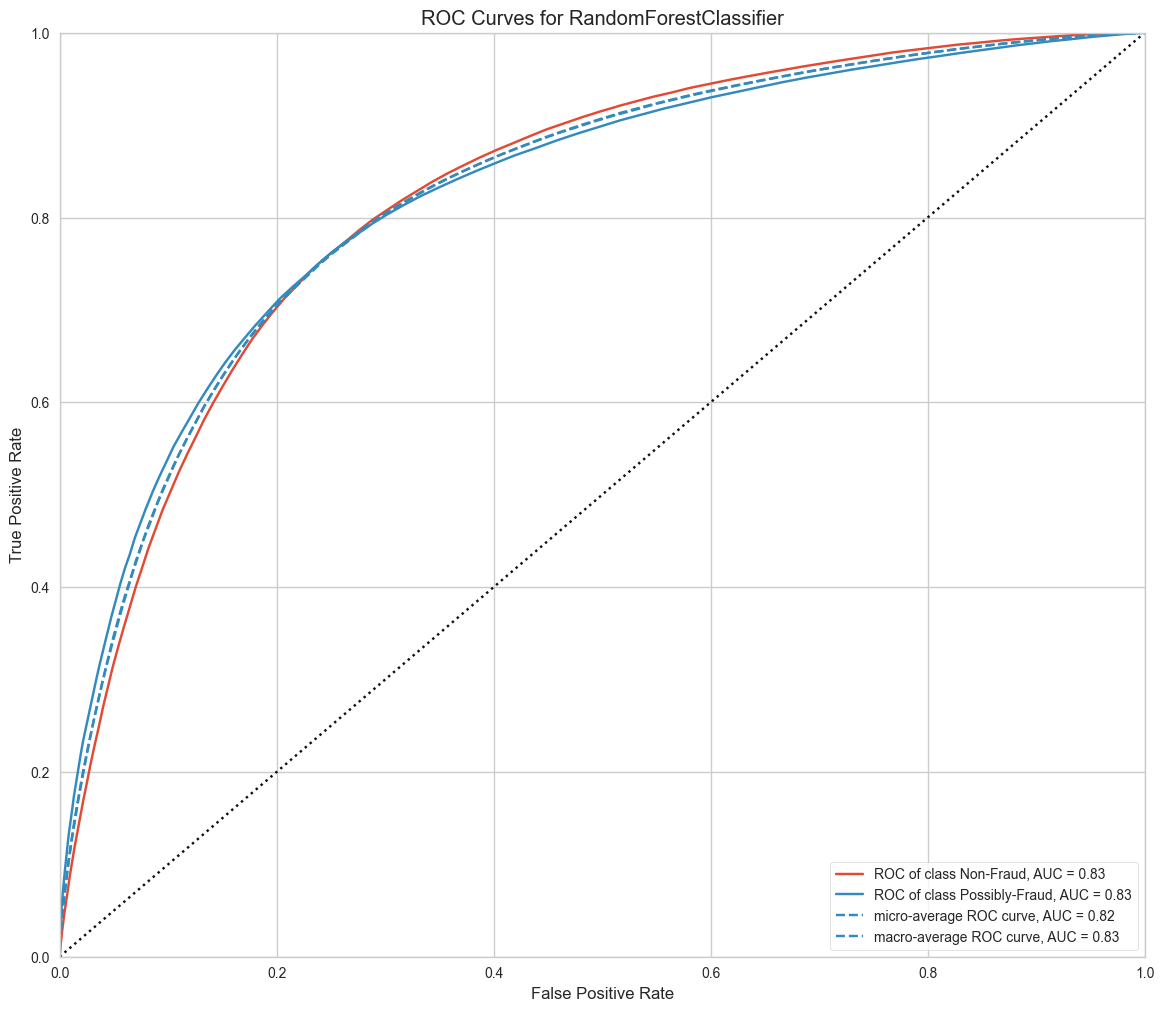

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [73]:
# AUC/ROC curve

# Visualizing the AUC/ROC curve with Yellowbricks
plt.figure(figsize = (14,12))
sns.set_style("whitegrid")
visualizer = ROCAUC(rf_bsm, classes=['Non-Fraud', 'Possibly-Fraud'])
visualizer.fit(trainX_BSM[selected_feat2], trainY_BSM) # Fit the training data to the visualizer
visualizer.score(testX_BSM[selected_feat2], testY_BSM) # Evaluate the model on the test data
visualizer.show()

#### Classification Report

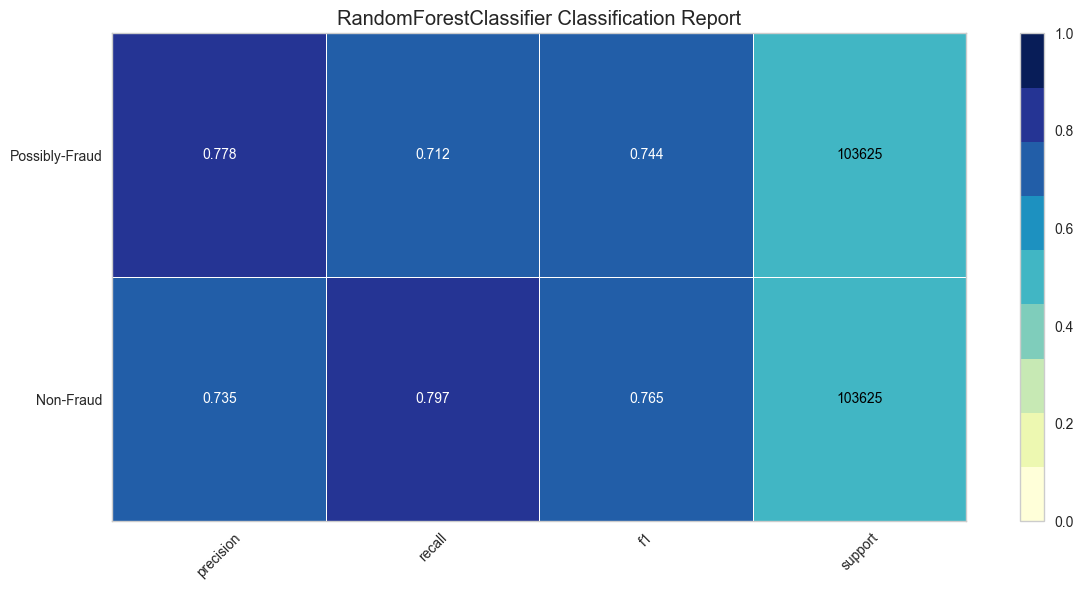

In [74]:
# Visualizing the classification report with Yellowbricks
plt.figure(figsize = (12,6))
sns.set_style("whitegrid")
visualizer = classification_report(rf_bsm, trainX_BSM[selected_feat2], trainY_BSM, testX_BSM[selected_feat2], testY_BSM, 
                                   classes=['Non-Fraud', 'Possibly-Fraud'], cmap='YlGnBu', support=True)

#### Prediction Error

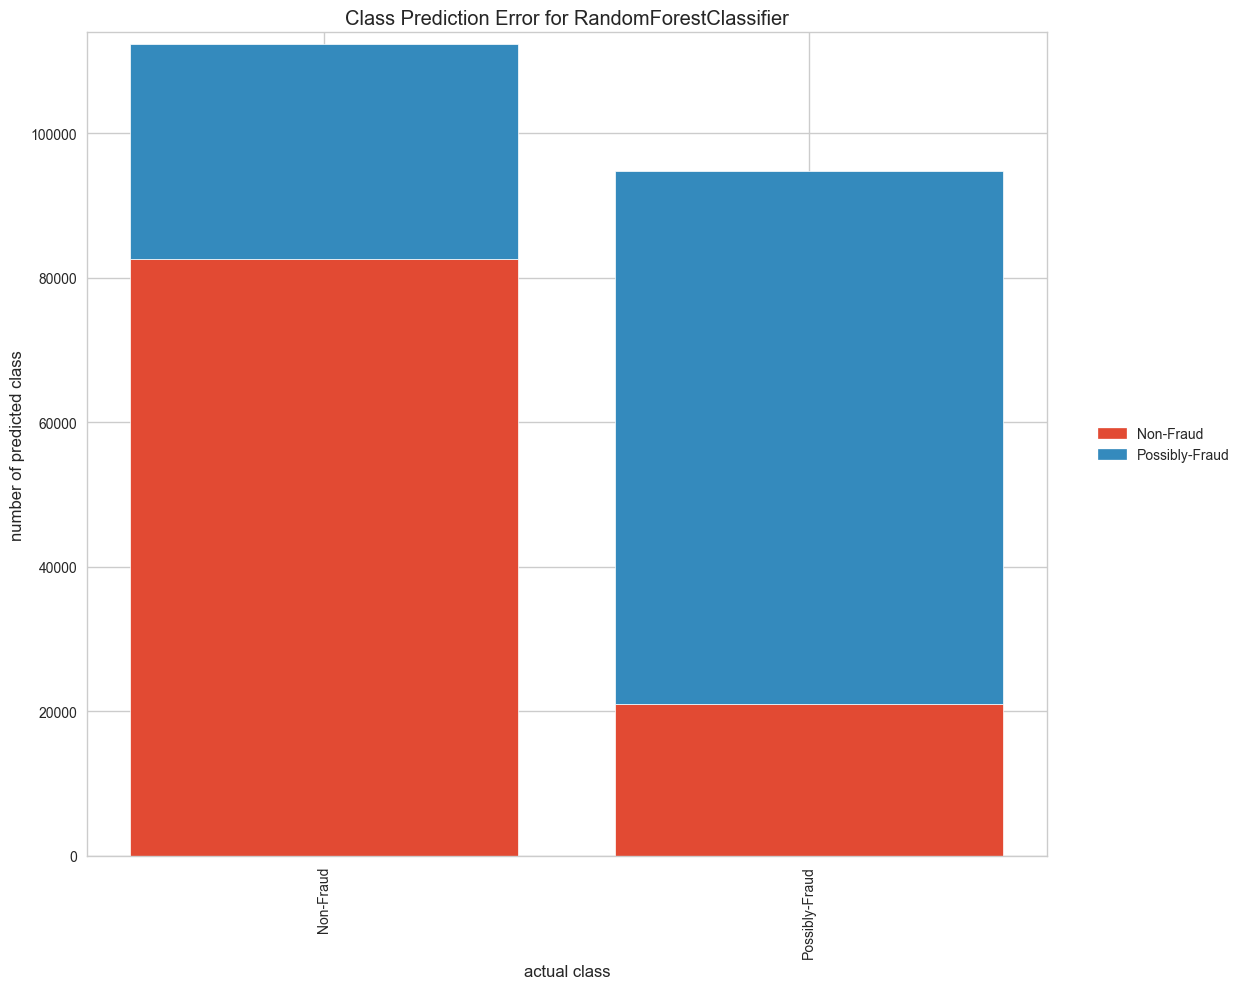

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [75]:
# Visualizing prediction error
from yellowbrick.classifier import class_prediction_error
plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
rf_bsm, trainX_BSM[selected_feat2], trainY_BSM.values.ravel(), testX_BSM[selected_feat2], testY_BSM.values.ravel(),classes=['Non-Fraud', 'Possibly-Fraud'])
viz.show()

In [ ]:
# Takes a really long time to load (over 40 minutes)
#BSMexplainer2 = shap.TreeExplainer(rf_bsm) 

#BSMshap_values2 = BSMexplainer(testX_BSM[selected_feat2])

In [ ]:
# Reduce the number of features (takes awhile to run)
reduced_testX_BSM = testX_BSM[selected_feat2]

# Sample your data (optional)
sampled_testX_BSM = reduced_testX_BSM.sample(n=1000, random_state=0)

# Use approximate method (optional)
BSMexplainer = shap.TreeExplainer(rf_bsm, approximate=True)

# Calculate SHAP values
BSMshap_values2 = BSMexplainer.shap_values(sampled_testX_BSM) 


### Explain the model's prediction using SHAP

In [ ]:
# Summary Plot
shap.summary_plot(BSMshap_values2)

### Random Forest Model using the same 10 features RFE selected for LightGBM

In [81]:
# Specify the 10 features we want to use
selected_features = ['State', 'County', 'Age', 'Tot_Reimbursed_Amt', 'Tot_Deductible_Amt',
                     'InscClaimAmtReimbursed', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
                     'Claim_Start_Month', 'Chr_Cond_Count']

# Filter the datasets to include only the selected features
trainX_BSM_filtered2 = trainX_BSM[selected_features]
testX_BSM_filtered2 = testX_BSM[selected_features]

# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(oob_score=True, random_state=42, max_depth=35,\
                                 min_samples_leaf=3, min_samples_split=6, n_estimators=125)

# Run the model with the filtered datasets
model_results(trainX_BSM_filtered2, trainY_BSM, testX_BSM_filtered2, testY_BSM, rf_model, show=True)

The Model Results for  RandomForestClassifier(max_depth=35, min_samples_leaf=3, min_samples_split=6,
                       n_estimators=125, oob_score=True, random_state=42)
************************************************************
Train Accuracy is equal to 0.939
Test Accuracy is equal to 0.765
The Precision score is 0.783
The Average Precision score is 0.708
The Recall score is 0.734
The F1 score is 0.757
The AUC/ROC score is 0.765
True-Positive: 76010.000
True-Negative: 82572.000
False-Positive: 21053.000
False-Negative: 27615.000
Correctly Classified: 158582.000
Incorrectly Classified: 48668.000


[0.9388064022498863,
 0.7651724969843184,
 0.7830996363186796,
 0.7335102533172497]

### Model metrics for final Random Forest Model

#### Confusion Matrix

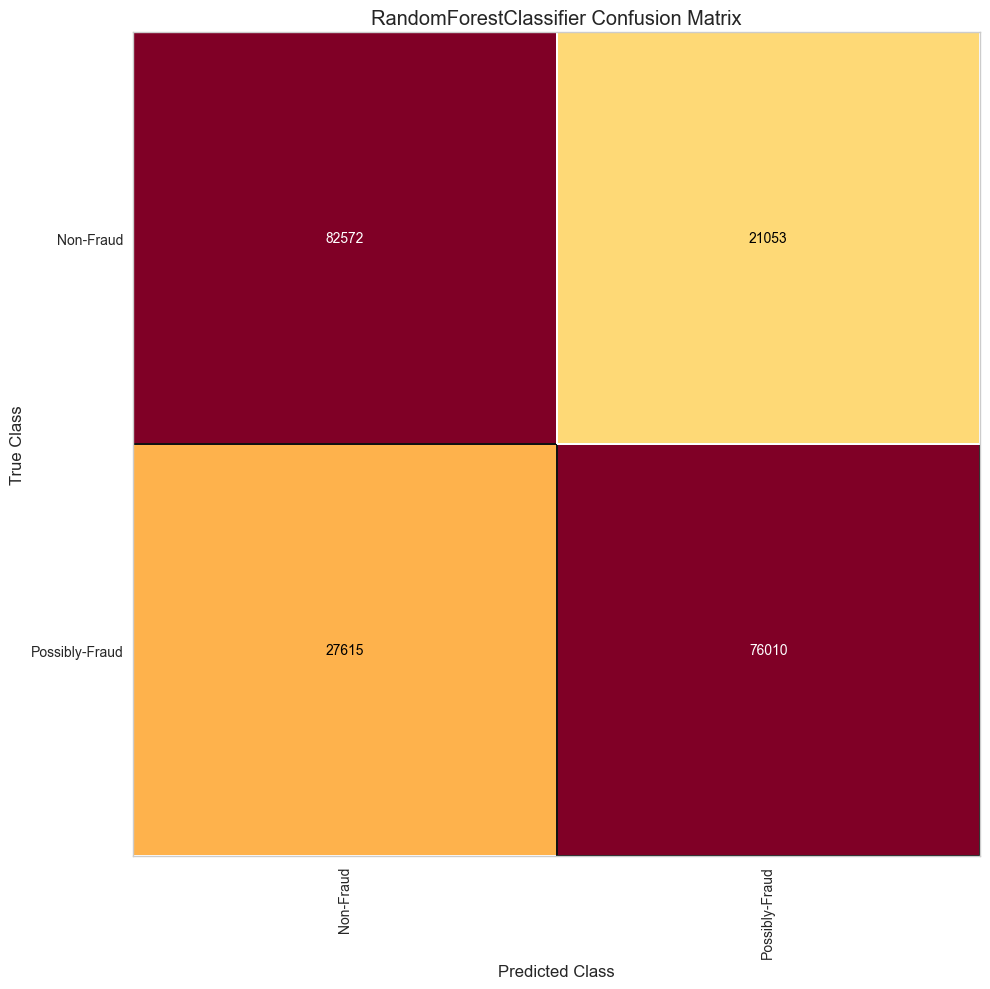

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [82]:
# Confusion Matrix

# Visualizing the confusion matrix with Yellowbricks (thres=0.5)
plt.figure(figsize=(10, 10))

# Create the ConfusionMatrix visualizer
visualizer = ConfusionMatrix(rf_model, classes=['Non-Fraud', 'Possibly-Fraud'])

# Fit the training data to the visualizer
visualizer.fit(trainX_BSM_filtered2[selected_features], trainY_BSM)

# Evaluate the model on the test data
visualizer.score(testX_BSM_filtered2[selected_features], testY_BSM)

# Draw/save/show the data
visualizer.show()

#### AUC/ROC Curve

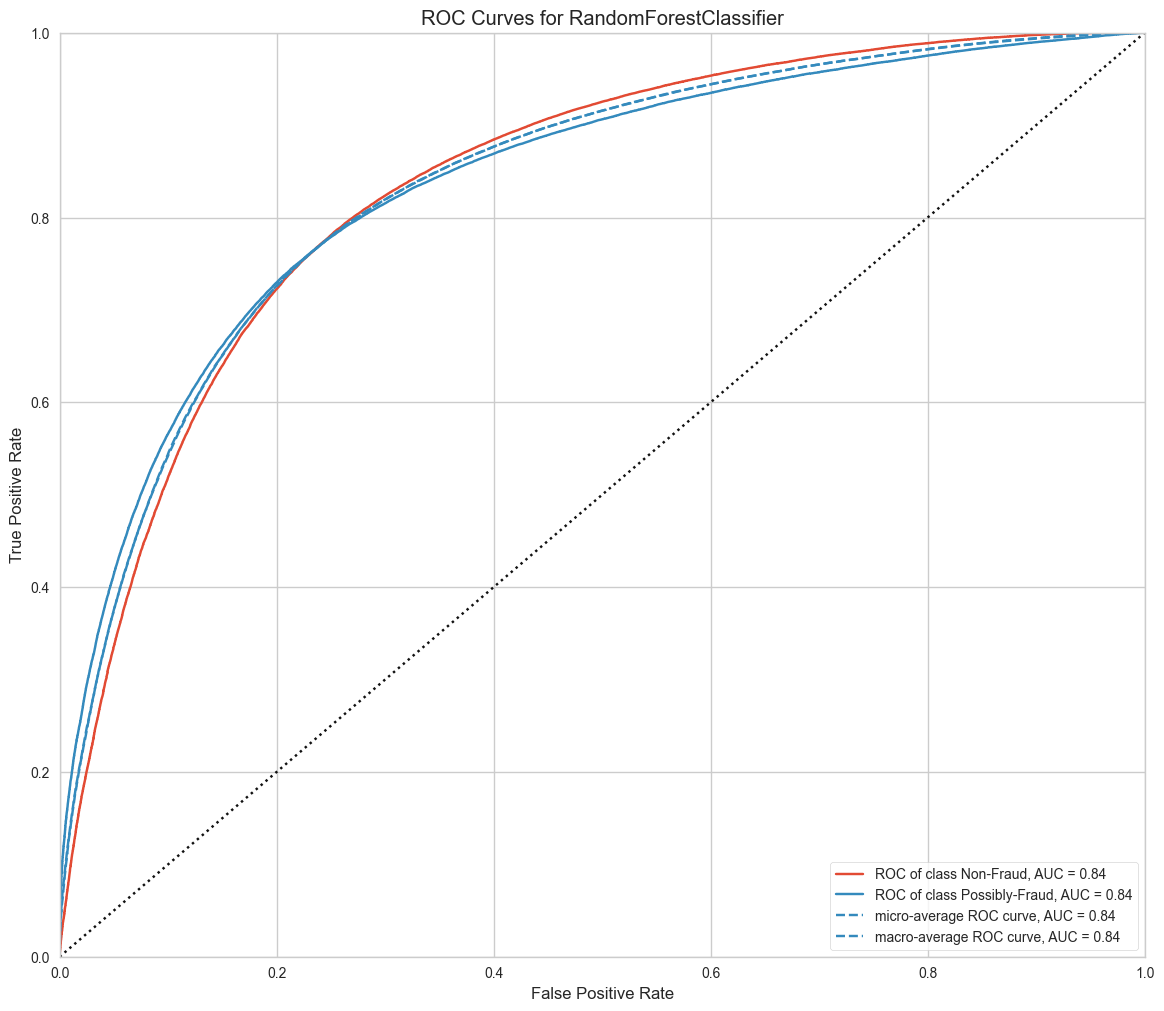

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [83]:
# AUC/ROC curve

# Visualizing the AUC/ROC curve with Yellowbricks
plt.figure(figsize = (14,12))
sns.set_style("whitegrid")
visualizer = ROCAUC(rf_model, classes=['Non-Fraud', 'Possibly-Fraud'])
visualizer.fit(trainX_BSM_filtered2[selected_features], trainY_BSM) # Fit the training data to the visualizer
visualizer.score(testX_BSM_filtered2[selected_features], testY_BSM) # Evaluate the model on the test data
visualizer.show()

#### Classification Report

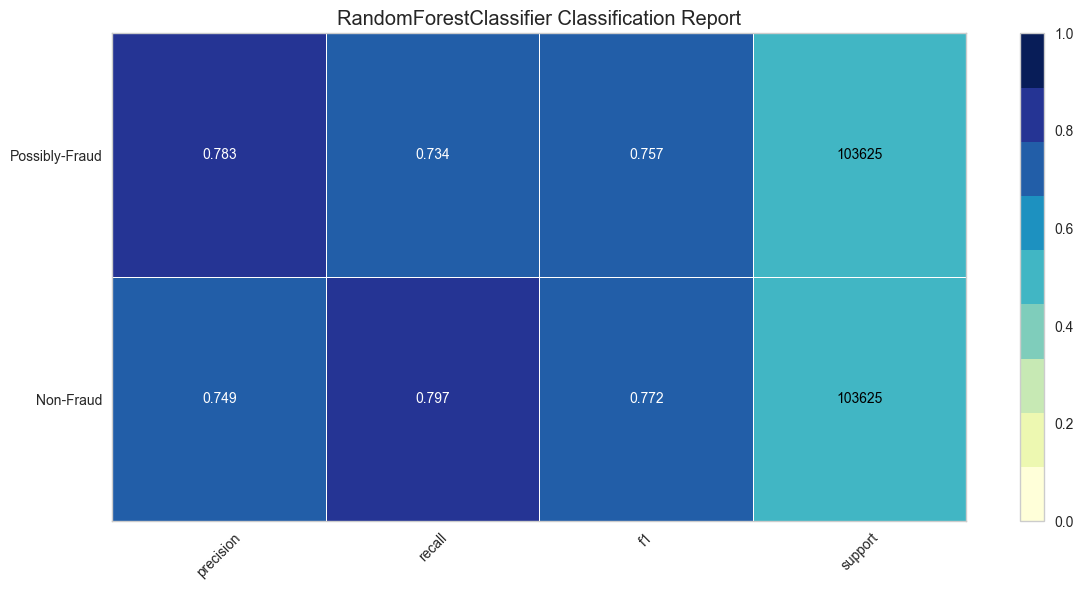

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [84]:
# Visualize the classification report with Yellowbrick
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

visualizer = classification_report(
    rf_model,
    trainX_BSM_filtered2, trainY_BSM, testX_BSM_filtered2, testY_BSM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True
)
visualizer.show()

#### Prediction Error

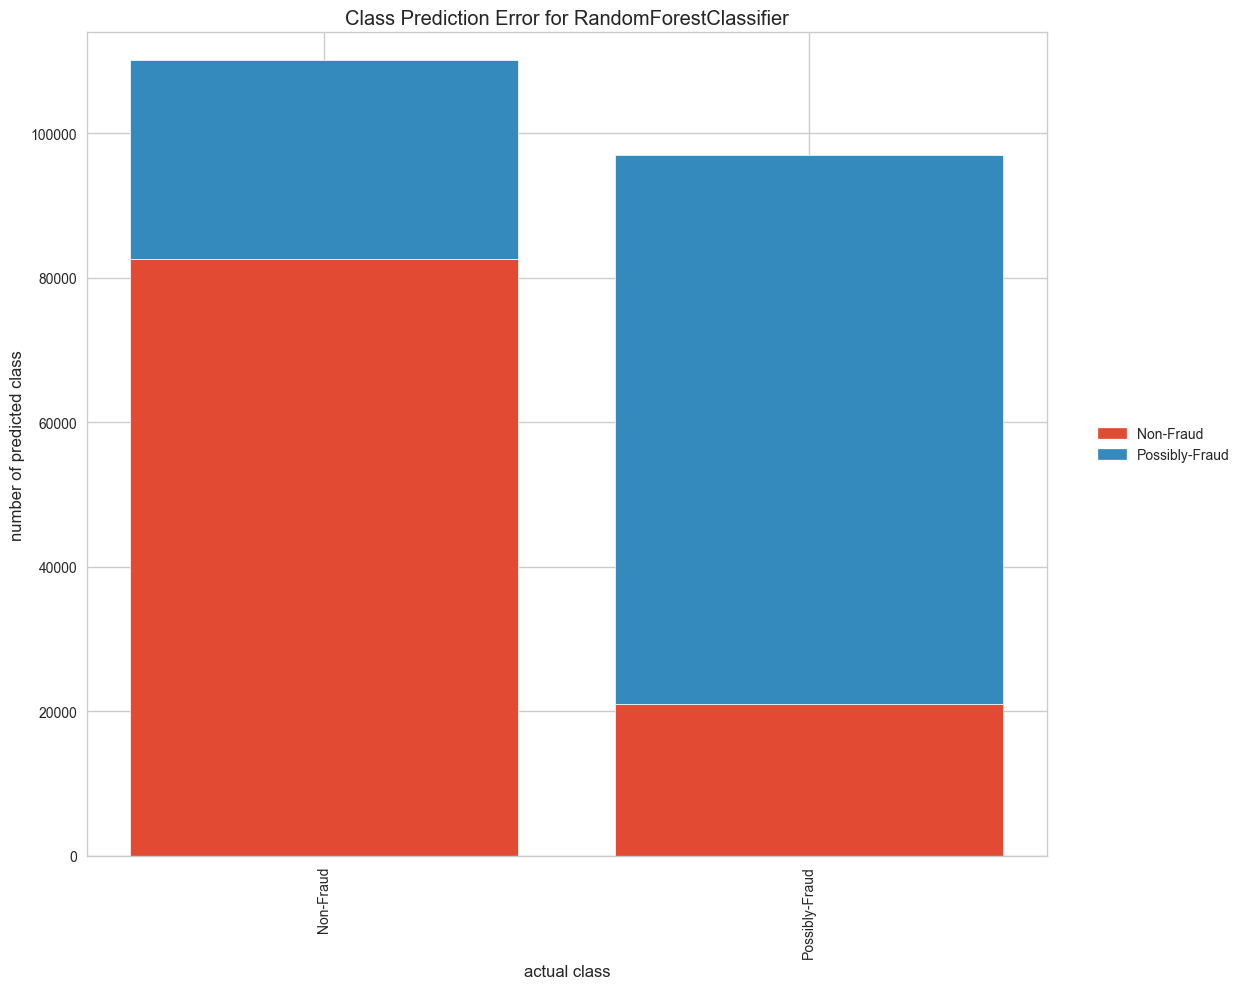

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [85]:
# Visualizing prediction error
from yellowbrick.classifier import class_prediction_error
plt.figure(figsize = (14,10))
sns.set_style("whitegrid")
viz = class_prediction_error(
rf_model, trainX_BSM_filtered2[selected_features], trainY_BSM.values.ravel(), testX_BSM_filtered2[selected_features], testY_BSM.values.ravel(),classes=['Non-Fraud', 'Possibly-Fraud'])
viz.show()

#### Model Explanation of Predictions - Using SHAP

In [94]:
#BSMexplainer3 = shap.TreeExplainer(rf_model)
#BSMshap_values3 = BSMexplainer3.shap_values(testX_BSM_filtered2[selected_features])

In [ ]:
# Summary Plot
#shap.summary_plot(BSMshap_values2, testX_BSM_filtered[selected_features])

---
## Best Models Comparison
---

We compare the three best models using the same 10 variables.

In [20]:
data = {'Model': ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest',\
                  'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',\
                  'LightGBM', 'LightGBM', 'LightGBM', 'LightGBM', 'LightGBM'],
        'Scores': [0.765, 0.783, 0.734, 0.757, 0.765,\
                   0.790, 0.816, 0.750, 0.781, 0.790,\
                   0.807, 0.832, 0.769, 0.799, 0.807],
        'Metric': ['Accuracy','Precision','Recall','F1 Score','AUC/ROC Score',\
                    'Accuracy','Precision','Recall','F1 Score','AUC/ROC Score',\
                    'Accuracy','Precision','Recall','F1 Score','AUC/ROC Score']}

In [21]:
# convert to DataFrame
BSM_df = pd.DataFrame(data)
BSM_df

,Model,Scores,Metric
0,Random Forest,0.765,Accuracy
1,Random Forest,0.783,Precision
2,Random Forest,0.734,Recall
3,Random Forest,0.757,F1 Score
4,Random Forest,0.765,AUC/ROC Score
5,XGBoost,0.790,Accuracy
6,XGBoost,0.816,Precision
7,XGBoost,0.750,Recall
8,XGBoost,0.781,F1 Score
9,XGBoost,0.790,AUC/ROC Score


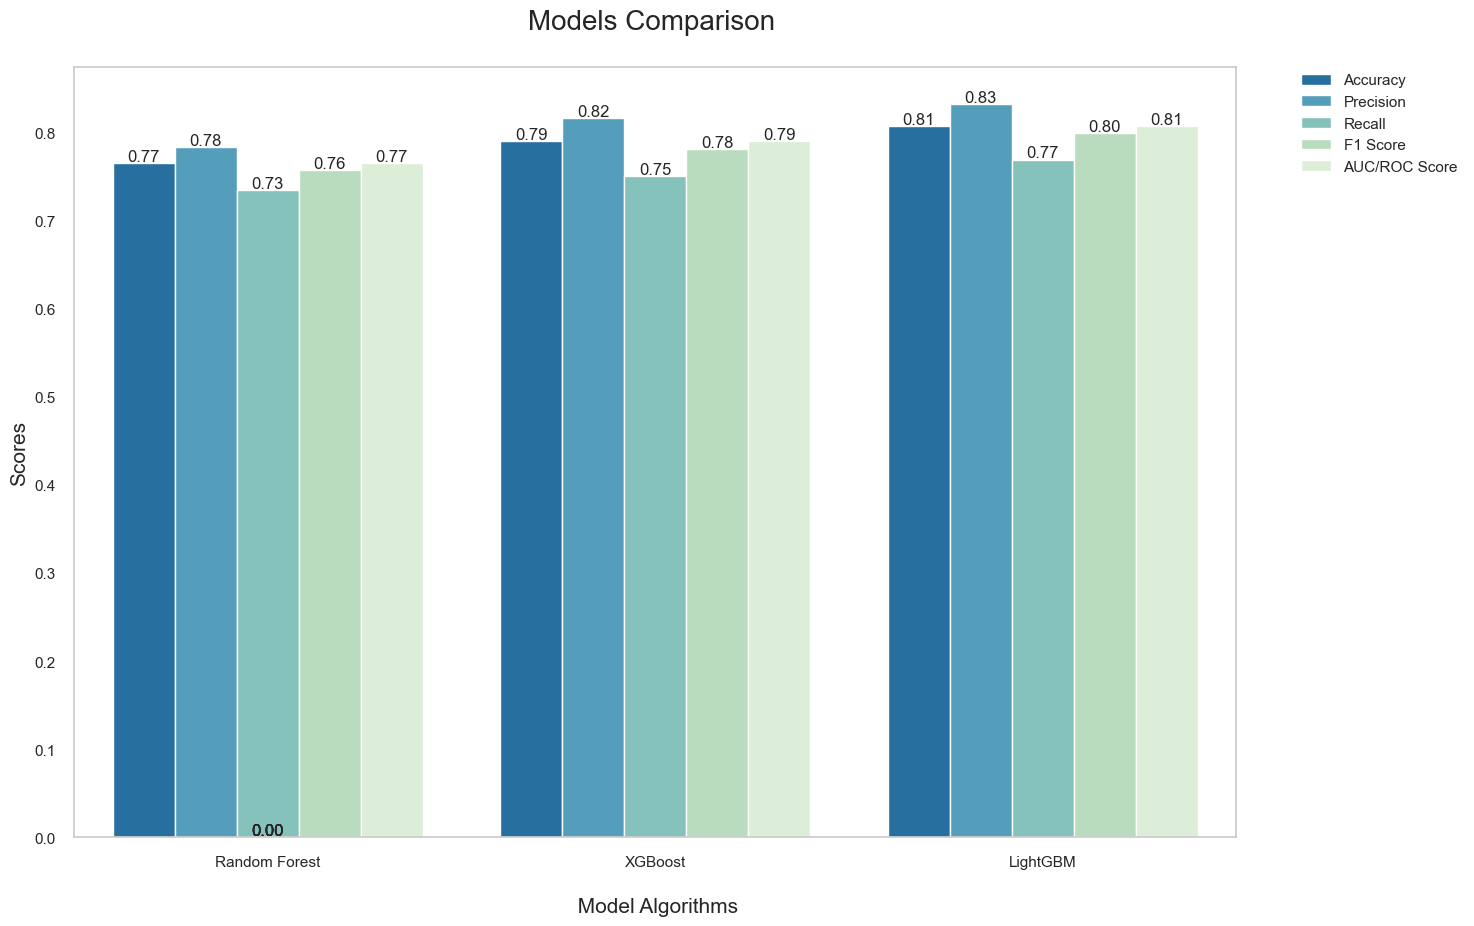

In [41]:
plt.figure(figsize=(15, 10))
sns.set_theme(style='whitegrid')

# Plotting barplot
splot = sns.barplot(data=BSM_df, x='Model', y='Scores', hue='Metric', palette='GnBu_r')

# Adding annotations with rounded values
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=12,
                   xytext=(0, 5), 
                   textcoords='offset points')

# Additional formatting
#plt.xticks(rotation=45)
plt.xlabel("\n Model Algorithms", fontsize=15)
plt.ylabel("Scores", fontsize=15)
plt.title("Models Comparison \n", fontsize=20)

# Move legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove the grid
plt.grid(False) 

plt.show()